# Propensity Matching / Treatment Prediction for Sepsis

## What is Sepsis?

Sepsis is a life-threatening condition that arises when the body's response to infection causes widespread inflammation and organ dysfunction. It represents a medical emergency requiring rapid intervention, as it can quickly progress to septic shock, characterized by severe drops in blood pressure, reduced tissue perfusion, and multi-organ failure. Sepsis is a leading cause of mortality in intensive care units (ICUs), with mortality rates ranging from 10% to 40% depending on severity.

Early recognition and appropriate treatment are critical. The primary therapeutic interventions include:
- **Fluid resuscitation** to maintain adequate blood pressure and tissue perfusion
- **Vasopressors** (such as norepinephrine) to restore vascular tone when fluids alone are insufficient
- **Antibiotics** to treat the underlying infection
- **Supportive care** to prevent or mitigate organ dysfunction

## Our Goal

The goal of this analysis is to develop a **treatment recommendation system** for sepsis patients based on propensity score matching and machine learning. Specifically, we aim to:

1. **Learn from historical patient data**: Identify patterns in how different patients with similar baseline characteristics responded to varying treatment intensities
2. **Predict optimal treatment strategies**: For a new patient presenting with sepsis, recommend the vasopressor dose and fluid management strategy most likely to improve outcomes
3. **Balance multiple outcomes**: Consider not just survival, but also organ function recovery (SOFA score changes) and metabolic improvement (lactate clearance)

By leveraging historical ICU data from the MIMIC-IV database, we can create a data-driven clinical decision support tool that helps clinicians optimize treatment for each individual patient based on their unique physiological profile.

The very definition of sepsis is actually blurred and subject to error.

## Loading Dependencies

In [9]:
# --- Importing required libraries and setting global configurations ---

from typing import Dict, Optional, List                   # type hints for dictionaries, optional values, and lists

import numpy as np                                        # numerical computing library for arrays and math
import pandas as pd                                       # data manipulation library for working with DataFrames (tables)
from sklearn.preprocessing import StandardScaler          # scales features to mean=0 and std=1
from sklearn.metrics.pairwise import euclidean_distances  # computes pairwise Euclidean distances between vectors
import matplotlib.pyplot as plt                           # plotting library for creating figures
import seaborn as sns                                     # high-level plotting library built on top of matplotlib
from tqdm.notebook import tqdm                            # progress bar for loops (works nicely in Jupyter notebooks)

sns.set_style("whitegrid")                                # set Seaborn’s visual style to have white background + gridlines
np.random.seed(42)                                        # fix random seed for reproducibility (ensures same random results every run)

In [65]:
list(mimic_df.columns)

['row_id',
 'pao2_fio2',
 'mechvent',
 'iv_fluid_input',
 'crrt',
 'time_since_admission',
 'age',
 'creatinine',
 'gcs',
 'vasopressor_dose',
 'cumulated_fluid_balance',
 'arterial_lactate',
 'stay_id',
 'baseline_sofa',
 'lactate_clearance_pct',
 'sofa_change',
 'outcome_score',
 'vaso_bin',
 'fluid_bin']

## Step 1: Load Sepsis Patient Data (extracted from MIMIC-IV)

Retrieve features to categorize our patients:

- **Patient features**: Demographics, vital signs, lab values
- **Treatments**: Vasopressor doses, IV fluid inputs  
- **Outcomes**: SOFA scores, lactate clearance, SOFA changes

In [10]:
# Load the sepsis patient dataframe
mimic_df = pd.read_parquet("sepsis_datasets.parquet")

print(f"Loaded {len(mimic_df):,} sepsis patient records")
print(f"Columns: {mimic_df.columns.tolist()}")
print(f"\nDataframe shape: {mimic_df.shape}")
print(f"\nData types:\n{mimic_df.dtypes}")
print(mimic_df.info())

# around 1.5 million entries

Loaded 1,503,626 sepsis patient records
Columns: ['row_id', 'pao2_fio2', 'mechvent', 'iv_fluid_input', 'crrt', 'time_since_admission', 'age', 'creatinine', 'gcs', 'vasopressor_dose', 'cumulated_fluid_balance', 'arterial_lactate', 'stay_id', 'baseline_sofa', 'lactate_clearance_pct', 'sofa_change']

Dataframe shape: (1503626, 16)

Data types:
row_id                      object
pao2_fio2                  float64
mechvent                     int32
iv_fluid_input             float64
crrt                         int32
time_since_admission         int64
age                        float64
creatinine                 float64
gcs                        float64
vasopressor_dose           float64
cumulated_fluid_balance    float64
arterial_lactate           float64
stay_id                     object
baseline_sofa              float64
lactate_clearance_pct      float64
sofa_change                float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503626 entries, 0 to 1503625
Dat

In [11]:
# Display sample data
print("Sample patient records:")
display(mimic_df.head())

Sample patient records:


,row_id,pao2_fio2,mechvent,iv_fluid_input,crrt,time_since_admission,age,creatinine,gcs,vasopressor_dose,cumulated_fluid_balance,arterial_lactate,stay_id,baseline_sofa,lactate_clearance_pct,sofa_change
0,006460_300,181.810138,0,1003.947622,0,0,43.0,3.583,15.0,0.0,1003.947622,2.414,006460,6.0,NaN,NaN
1,006461_300,165.048422,0,1008.948128,0,1,43.0,0.900,15.0,0.0,1008.948128,3.584,006461,3.0,NaN,NaN
2,006462_300,165.222365,0,1013.948635,0,2,43.0,0.900,15.0,0.0,1013.948635,3.583,006462,3.0,NaN,NaN
3,006463_300,165.262564,0,1018.949141,0,3,43.0,0.900,15.0,0.0,1018.949141,3.583,006463,3.0,NaN,NaN
4,006464_300,188.920221,0,1383.949648,0,4,43.0,0.900,15.0,0.0,683.949648,2.859,006464,3.0,NaN,NaN


Comment:

missing:

-inflammatory markers

-urine output ml/kg/h

-antibiotics + how many

-what time started vasopressors

-what kind of vasopressors

-which time blood test?

-is it viral vs bacteria from blood test

-on oxygen or room air? (or as a proxy, fi02 as a measure)

-BMI

-commorbities (e.g. heart failure => giving too much fluids could harm the patient)

In [12]:
# key physiological features that represent the patient's state -> to show baseline physiological diversity
features = ["age", "baseline_sofa", "arterial_lactate", "pao2_fio2", "creatinine"]

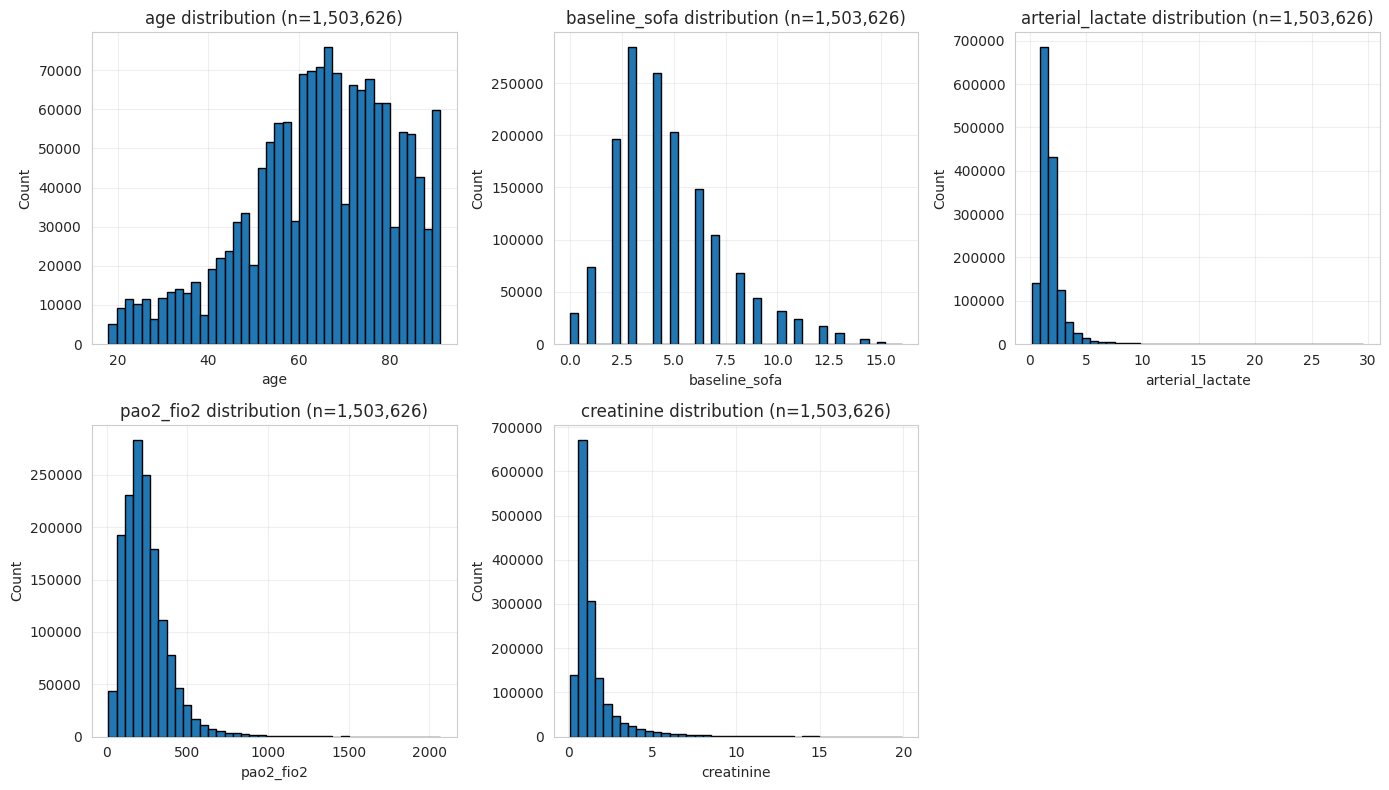

In [13]:
# Calculate how many rows are needed to display all features
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols)) # np.ceil() rounds up to ensure enough rows even if last one isn't full

# Create a new figure sized proportionally to the number of rows (14 wide, 4 inches tall per row)
plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(features, 1):
    # Loop through all feature names, starting the counter (i) at 1 for subplot indexing
    if col not in mimic_df.columns: # Skip this feature if it's not actually a column in the DataFrame
        continue
    plt.subplot(n_rows, n_cols, i)                        # Create the i-th subplot in a grid of (n_rows × n_cols)
    data = mimic_df[col].dropna()                         # Extract the column’s data, dropping missing values (NaN)
    plt.hist(data, bins=40, edgecolor="black")            # Plot a histogram of the feature using 40 bins, with black edges for clarity
    plt.title(f"{col} distribution (n={len(data):,})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

  * **Age:** right-skewed toward older adults → most patients between 60–80 years.
  * **Baseline SOFA:** peaks around 3–5 → moderate organ dysfunction is most common.
  * **Arterial lactate:** highly right-skewed → many patients with near-normal lactate, few with severe elevations.
  * **PaO₂/FiO₂:** long right tail → majority have impaired oxygenation.
  * **Creatinine:** right-skewed → most have normal kidney function, minority with renal failure.

- Question:
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

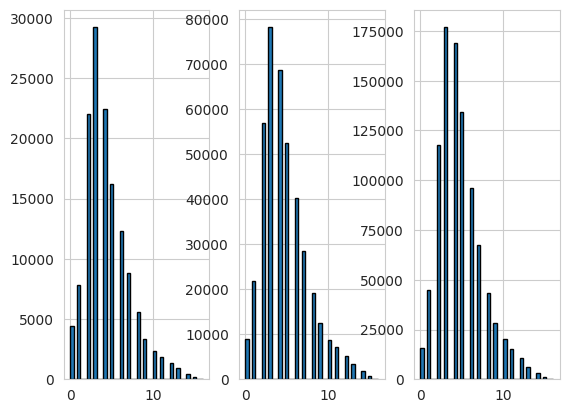

In [14]:
col = "baseline_sofa"
data1 = mimic_df[mimic_df["age"] <= 40]
data2 = mimic_df[(mimic_df["age"] > 40) & (mimic_df["age"] <= 60)]
data3 = mimic_df[mimic_df["age"] > 60]
data1 = data1[col].dropna()
data2 = data2[col].dropna()
data3 = data3[col].dropna()

fig, axs = plt.subplots(1, 3)
axs[0].hist(data1, bins=40, edgecolor="black")
axs[1].hist(data2, bins=40, edgecolor="black")
axs[2].hist(data3, bins=40, edgecolor="black")
plt.show()

### Rationale for Feature and Outcome Selection


For our treatment recommendation system, we focus on **actionable decision points** where clinicians have complete information to make treatment decisions and assess their impact. We filter the dataset to retain only observations with:

#### Required Outcomes (at least one):
- **Lactate Clearance %**: The percentage change in arterial lactate over time. Positive values indicate lactate is being cleared (improvement), while negative values indicate lactate is increasing (worsening). Lactate clearance is a validated therapeutic target in sepsis resuscitation.
- **SOFA Score Change**: The Sequential Organ Failure Assessment (SOFA) score quantifies the degree of organ dysfunction across six systems (respiratory, coagulation, liver, cardiovascular, renal, and neurological). Changes in SOFA score indicate whether the patient is improving (negative change) or deteriorating (positive change), making it a crucial outcome metric.

#### Required Actions (at least one):
- **Vasopressor Dose**: Vasopressors (primarily norepinephrine) are catecholamines that restore vascular tone and increase blood pressure in septic shock. The dose reflects the severity of vasodilatory shock and the intensity of cardiovascular support. Proper titration is critical—too little results in inadequate perfusion, while excessive doses can cause vasoconstriction-related complications.
- **IV Fluid Input**: Intravenous fluid resuscitation is the first-line treatment for sepsis-induced hypoperfusion. Early aggressive fluid administration aims to restore intravascular volume and improve cardiac output. However, the optimal fluid strategy is debated, as excessive fluids can lead to pulmonary edema and tissue edema.



### Why These Features for Sepsis Treatment?

In sepsis management, clinicians continuously adjust vasopressor doses and fluid administration based on hemodynamic parameters and metabolic markers. The relationship between these interventions and outcomes is complex and patient-specific:

- **Individual Variability**: Patients respond differently to the same treatment based on their baseline physiology, comorbidities, and infection severity
- **Non-linear Relationships**: Both inadequate and excessive treatment can be harmful (e.g., under-resuscitation leads to organ damage, while over-resuscitation causes fluid overload)
- **Multiple Competing Outcomes**: Clinicians must balance immediate hemodynamic goals (blood pressure) with longer-term outcomes (organ function, survival)

By analyzing historical data, we can identify optimal treatment strategies for patients with similar baseline characteristics, effectively learning from thousands of past clinical decisions and their outcomes.

### Summarize Missing Data per Column
This step identifies which variables have missing values and how severe the missingness is (both in count and percentage). It helps decide which columns to drop, impute, or investigate further.

In [15]:
na_counts = mimic_df.isna().sum()

# Percentage of missing values per column
# Series[float] — same index, values = percentage of NaNs (0–100)
na_percent = (mimic_df.isna().mean() * 100).round(2)

# Combine both into a single DataFrame for readability
# DataFrame with two columns: 'n_missing' and 'missing_%'
missing_summary = pd.DataFrame({
    "n_missing": na_counts,
    "missing_%": na_percent
}).sort_values(by="missing_%", ascending=False)

print (missing_summary)

# Display top rows — shows columns with the most missingness first
print(f"Total columns: {mimic_df.shape[1]}, total rows: {mimic_df.shape[0]}")

                         n_missing  missing_%
sofa_change                1358954      90.38
lactate_clearance_pct      1358954      90.38
row_id                           0       0.00
pao2_fio2                        0       0.00
crrt                             0       0.00
time_since_admission             0       0.00
mechvent                         0       0.00
iv_fluid_input                   0       0.00
creatinine                       0       0.00
age                              0       0.00
gcs                              0       0.00
vasopressor_dose                 0       0.00
arterial_lactate                 0       0.00
cumulated_fluid_balance          0       0.00
baseline_sofa                    0       0.00
stay_id                          0       0.00
Total columns: 16, total rows: 1503626


### Visualize Differences Between Missing and Complete Groups
These histograms show whether patients missing outcome data differ meaningfully (e.g., younger, less sick, lower lactate). If their distributions differ, missingness is likely not random, which has implications for modeling and fairness.


Top columns with missing data: ['sofa_change', 'lactate_clearance_pct']


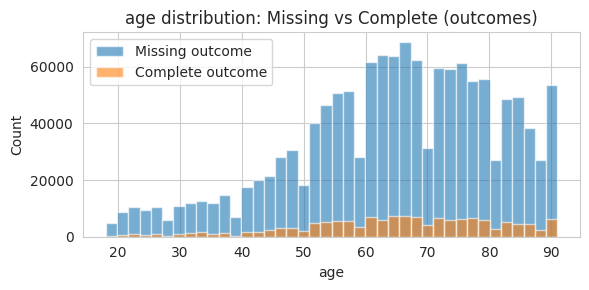

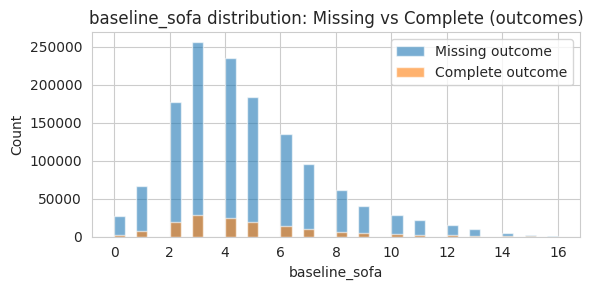

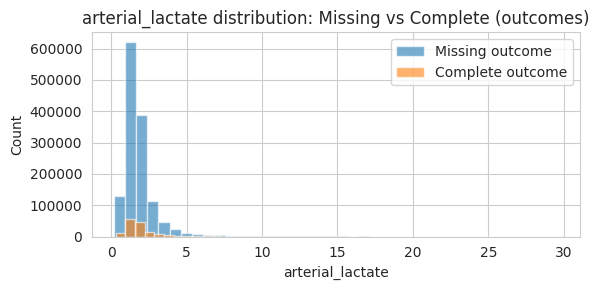

In [16]:
# choose top N columns with highest missingness
top_missing_cols = missing_summary.head(2).index.tolist()
print(f"\nTop columns with missing data: {top_missing_cols}")

# create subsets:
# df_missing: rows where ANY of these top columns are missing
# df_complete: rows where ALL these top columns are present
df_missing = mimic_df[mimic_df[top_missing_cols].isna().any(axis=1)]
df_complete = mimic_df[mimic_df[top_missing_cols].notna().all(axis=1)]


# features to compare
compare_features = ["age", "baseline_sofa", "arterial_lactate"]

for feat in compare_features:
    plt.figure(figsize=(6,3))
    plt.hist(df_missing[feat].dropna(), bins=40, alpha=0.6, label="Missing outcome")
    plt.hist(df_complete[feat].dropna(), bins=40, alpha=0.6, label="Complete outcome")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title(f"{feat} distribution: Missing vs Complete (outcomes)")
    plt.legend()
    plt.tight_layout()
    plt.show()


- Question:
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

### Filtering Criteria



We keep only records where we can both:
1. **Observe meaningful outcomes**: At least one valid outcome measurement (lactate clearance % OR SOFA change)
2. **Track treatment actions**: At least one recorded intervention (vasopressor dose OR IV fluid input)

This ensures every record in our analysis represents a complete clinical decision point suitable for learning treatment policies.

In [17]:
# Apply filtering criteria
print("=" * 80)
print("FILTERING DATASET FOR COMPLETE OBSERVATIONS")
print("=" * 80)

initial_count = len(mimic_df)
print(f"\nInitial dataset: {initial_count:,} records")

# Filter 1: At least one outcome measure (lactate_clearance_pct OR sofa_change)
has_lactate_clearance = mimic_df["lactate_clearance_pct"].notna()
has_sofa_change = mimic_df["sofa_change"].notna()
has_outcome = has_lactate_clearance | has_sofa_change

outcome_count = has_outcome.sum()
print(f"\nFilter 1 - Has at least one outcome:")
print(f"  Records with lactate clearance: {has_lactate_clearance.sum():,}")
print(f"  Records with SOFA change: {has_sofa_change.sum():,}")
print(
    f"  Records with at least one outcome: {outcome_count:,} ({100*outcome_count/initial_count:.1f}%)"
)

# Filter 2: At least one action (vasopressor OR iv_fluid)
has_vasopressor = mimic_df["vasopressor_dose"].notna()
has_iv_fluid = mimic_df["iv_fluid_input"].notna()
has_action = has_vasopressor | has_iv_fluid

action_count = has_action.sum()
print(f"\nFilter 2 - Has at least one action:")
print(f"  Records with vasopressor dose: {has_vasopressor.sum():,}")
print(f"  Records with IV fluid input: {has_iv_fluid.sum():,}")
print(
    f"  Records with at least one action: {action_count:,} ({100*action_count/initial_count:.1f}%)"
)

# Combined filter
complete_observations = has_outcome & has_action
mimic_df_filtered = mimic_df[complete_observations].copy()

print(f"\n" + "-" * 80)
print(f"After filtering: {len(mimic_df_filtered):,} records")
print(f"Retained: {100*len(mimic_df_filtered)/initial_count:.1f}% of original data")
print(f"Removed: {initial_count - len(mimic_df_filtered):,} records")
print("-" * 80)

# Update the main dataframe
mimic_df = mimic_df_filtered

print(f"\nFinal dataset ready: {len(mimic_df):,} complete decision points")

FILTERING DATASET FOR COMPLETE OBSERVATIONS

Initial dataset: 1,503,626 records

Filter 1 - Has at least one outcome:
  Records with lactate clearance: 144,672
  Records with SOFA change: 144,672
  Records with at least one outcome: 144,672 (9.6%)

Filter 2 - Has at least one action:
  Records with vasopressor dose: 1,503,626
  Records with IV fluid input: 1,503,626
  Records with at least one action: 1,503,626 (100.0%)

--------------------------------------------------------------------------------
After filtering: 144,672 records
Retained: 9.6% of original data
Removed: 1,358,954 records
--------------------------------------------------------------------------------

Final dataset ready: 144,672 complete decision points


In [18]:
# Filter to keep only records with baseline SOFA scores
if mimic_df["baseline_sofa"].isna().any():
    mimic_df = mimic_df[mimic_df["baseline_sofa"].notna()].copy()

print(f"\nFinal processed dataset: {len(mimic_df):,} complete observations")

# same number of entries - as baseline_sofa has no missing values


Final processed dataset: 144,672 complete observations


### ProfileReport
Generate a complete and exhaustive report for the dataset, with many features and customizations in the generated report


In [19]:
# %%time

# from ydata_profiling import ProfileReport

# profile = ProfileReport(mimic_df, title = "Report")
# profile.to_notebook_iframe()

# # Save the report to an HTML file
# profile.to_file("/Users/mac/Desktop/Dubai-Datathon-2025/profile-report.html")

# # note: takes around 20 seconds to run

### Histogram of time_since_admission

Visualize how many decision points occur at different times since ICU admission — to see if most actions happen early (e.g., in first 24–48h) or later in the stay.

Mean time since admission: 25.7 h
Median time since admission: 22.0 h
Max time since admission: 96.0 h


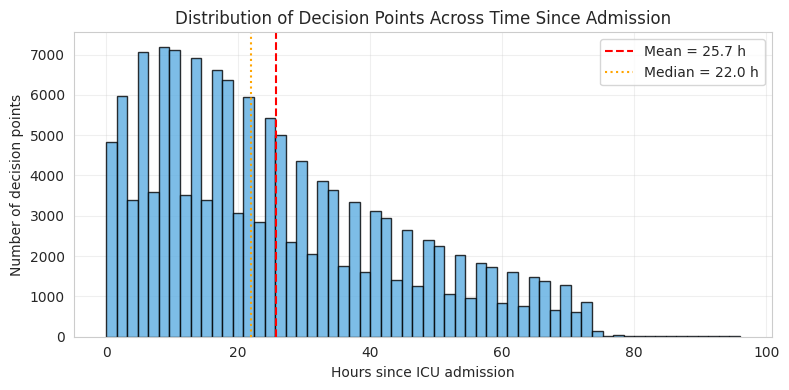

In [20]:

# Extract the time variable (in hours)
time_data = mimic_df["time_since_admission"].astype(float)

# Compute basic stats to include in the title
mean_time = time_data.mean()
median_time = np.median(time_data)
max_time = time_data.max()

print(f"Mean time since admission: {mean_time:.1f} h")
print(f"Median time since admission: {median_time:.1f} h")
print(f"Max time since admission: {max_time:.1f} h")

# Create histogram
plt.figure(figsize=(8, 4))
plt.hist(time_data, bins=60, edgecolor="black", color="#5dade2", alpha=0.8)

# Add reference lines for median and mean
plt.axvline(mean_time, color="red", linestyle="--", label=f"Mean = {mean_time:.1f} h")
plt.axvline(median_time, color="orange", linestyle=":", label=f"Median = {median_time:.1f} h")

# Annotate and label
plt.title("Distribution of Decision Points Across Time Since Admission")
plt.xlabel("Hours since ICU admission")
plt.ylabel("Number of decision points")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- Question:
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

24h way too late to make an AI-assisted intervention

treatment has to be optimal as soon as the patients arrive in the emergency

every 10/15min reasses patients care sometimes

## Step 3: Define categories - patient features, treatment actions, outcomes

We create a composite outcome score that combines available metrics:
1. **SOFA score change** (negative = improvement)
2. **Lactate clearance** (positive = improvement)

**Lactate Clinical Interpretation:**
- Normal lactate: 0.5-2.0 mmol/L
- Elevated: 2.0-4.0 mmol/L (concerning)
- Severe: >4.0 mmol/L (critical)
- Very severe: >10 mmol/L (life-threatening)

### Data Preparation

We filter to decision points that have: Valid arterial lactate measurements

In [21]:
# Additional filtering: keep only records with valid arterial_lactate

# These are needed as features for matching
mimic_df = mimic_df[
    (mimic_df["arterial_lactate"].notna())
    & (mimic_df["arterial_lactate"] > 0)
].copy()

print(f"After additional filtering: {len(mimic_df):,} decision points")
print(f"\nFinal dataset: {len(mimic_df):,} rows")

After additional filtering: 144,672 decision points

Final dataset: 144,672 rows


### Summary statistics

In [22]:
# Comprehensive summary statistics
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

# Define categories
feature_cols = [
    "age",
    "baseline_sofa",
    "arterial_lactate",
    "pao2_fio2",
    "creatinine",
    "gcs",
    "mechvent",
    "crrt",
    "time_since_admission",
    "cumulated_fluid_balance",
]

action_cols = ["vasopressor_dose", "iv_fluid_input"]

outcome_cols = ["sofa_change", "lactate_clearance_pct"]

# Filter to only existing columns
feature_cols = [col for col in feature_cols if col in mimic_df.columns]
action_cols = [col for col in action_cols if col in mimic_df.columns]
outcome_cols = [col for col in outcome_cols if col in mimic_df.columns]

print("\n" + "=" * 80)
print("PATIENT FEATURES")
print("=" * 80)
display(mimic_df[feature_cols].describe())

print("\n" + "=" * 80)
print("TREATMENT ACTIONS")
print("=" * 80)
display(mimic_df[action_cols].describe())

print("\n" + "=" * 80)
print("OUTCOMES")
print("=" * 80)


if outcome_cols:
    display(mimic_df[outcome_cols].describe())

    # Additional analysis for lactate_clearance_pct
    if "lactate_clearance_pct" in mimic_df.columns:
        print("\n" + "-" * 80)
        print("LACTATE CLEARANCE % - Detailed Analysis")
        print("-" * 80)
        lactate_data = mimic_df["lactate_clearance_pct"].dropna()
        print(f"Total observations: {len(lactate_data):,}")
        print(
            f"\nImproving patients (positive clearance): {(lactate_data > 0).sum():,} ({100*(lactate_data > 0).sum()/len(lactate_data):.1f}%)"
        )
        print(
            f"Worsening patients (negative clearance): {(lactate_data < 0).sum():,} ({100*(lactate_data < 0).sum()/len(lactate_data):.1f}%)"
        )
        print(f"No change: {(lactate_data == 0).sum():,}")
        print(
            f"\nExtreme worsening (<-100%): {(lactate_data < -100).sum():,} ({100*(lactate_data < -100).sum()/len(lactate_data):.1f}%)"
        )   # how many patients had a lactate clearance percentage below –100%, meaning their lactate more than doubled —> an extreme deterioration.
        print(
            f"Extreme improvement (>50%): {(lactate_data > 50).sum():,} ({100*(lactate_data > 50).sum()/len(lactate_data):.1f}%)"
        )

    if "sofa_change" in mimic_df.columns:
        print("\n" + "-" * 80)
        print("SOFA CHANGE - Detailed Analysis")
        print("-" * 80)
        sofa_data = mimic_df["sofa_change"].dropna()
        print(f"Total observations: {len(sofa_data):,}")
        print(
            f"\nImproving patients (negative change): {(sofa_data < 0).sum():,} ({100*(sofa_data < 0).sum()/len(sofa_data):.1f}%)"
        )
        print(
            f"Worsening patients (positive change): {(sofa_data > 0).sum():,} ({100*(sofa_data > 0).sum()/len(sofa_data):.1f}%)"
        )
        print(
            f"No change: {(sofa_data == 0).sum():,} ({100*(sofa_data == 0).sum()/len(sofa_data):.1f}%)"
        ) # how many patients had no change in their SOFA score, meaning their organ function neither improved nor worsened between timepoints

SUMMARY STATISTICS

PATIENT FEATURES


,age,baseline_sofa,arterial_lactate,pao2_fio2,creatinine,gcs,mechvent,crrt,time_since_admission,cumulated_fluid_balance
count,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000,144672.000000
mean,64.909450,4.590923,1.932310,239.473881,1.476616,12.052246,0.104920,0.012767,25.712591,3608.025035
std,16.026591,2.665931,1.316439,140.754435,1.426726,3.941265,0.306451,0.112267,18.583917,4647.798066
min,18.000000,0.000000,0.300000,12.000000,0.100000,3.000000,0.000000,0.000000,0.000000,-10275.475424
25%,55.000000,3.000000,1.300000,145.000000,0.700000,10.000000,0.000000,0.000000,11.000000,484.271154
50%,66.000000,4.000000,1.609000,215.466787,1.000000,14.000000,0.000000,0.000000,22.000000,2615.100870
75%,77.000000,6.000000,2.128000,300.000000,1.600000,15.000000,0.000000,0.000000,38.000000,5409.223020
max,91.000000,16.000000,25.900000,1776.666667,19.900000,15.000000,1.000000,1.000000,96.000000,63952.358639



TREATMENT ACTIONS


,vasopressor_dose,iv_fluid_input
count,144672.000000,144672.000000
mean,0.035436,5559.133644
std,0.146982,5009.900381
min,0.000000,0.000000
25%,0.000000,1950.000000
50%,0.000000,4551.079414
75%,0.000000,7740.908284
max,20.000000,71804.358639



OUTCOMES


,sofa_change,lactate_clearance_pct
count,144672.000000,144672.000000
mean,0.117846,-20.325488
std,3.793949,102.267462
min,-15.000000,-3187.500000
25%,-2.000000,-42.105263
50%,0.000000,1.173564
75%,2.000000,33.333333
max,15.000000,96.666667



--------------------------------------------------------------------------------
LACTATE CLEARANCE % - Detailed Analysis
--------------------------------------------------------------------------------
Total observations: 144,672

Improving patients (positive clearance): 73,086 (50.5%)
Worsening patients (negative clearance): 68,664 (47.5%)
No change: 2,922

Extreme worsening (<-100%): 15,731 (10.9%)
Extreme improvement (>50%): 17,654 (12.2%)

--------------------------------------------------------------------------------
SOFA CHANGE - Detailed Analysis
--------------------------------------------------------------------------------
Total observations: 144,672

Improving patients (negative change): 62,575 (43.3%)
Worsening patients (positive change): 64,716 (44.7%)
No change: 17,381 (12.0%)


Probably not the first measurement:

Why:

levels not that high (arterial lactate) + time since admission to the ICU quite high too (~24h)


Some hospitals minimum age for the "adult database" is 12 -> that would change our dataset

An intern added a 0 to some numbers (a medical student actually) -> there are some outliers

Otherwise, seems to follow the guidelines (e.g. roughly 6 l of fluid inputs)

### Pairwise Relationships among Patient Features

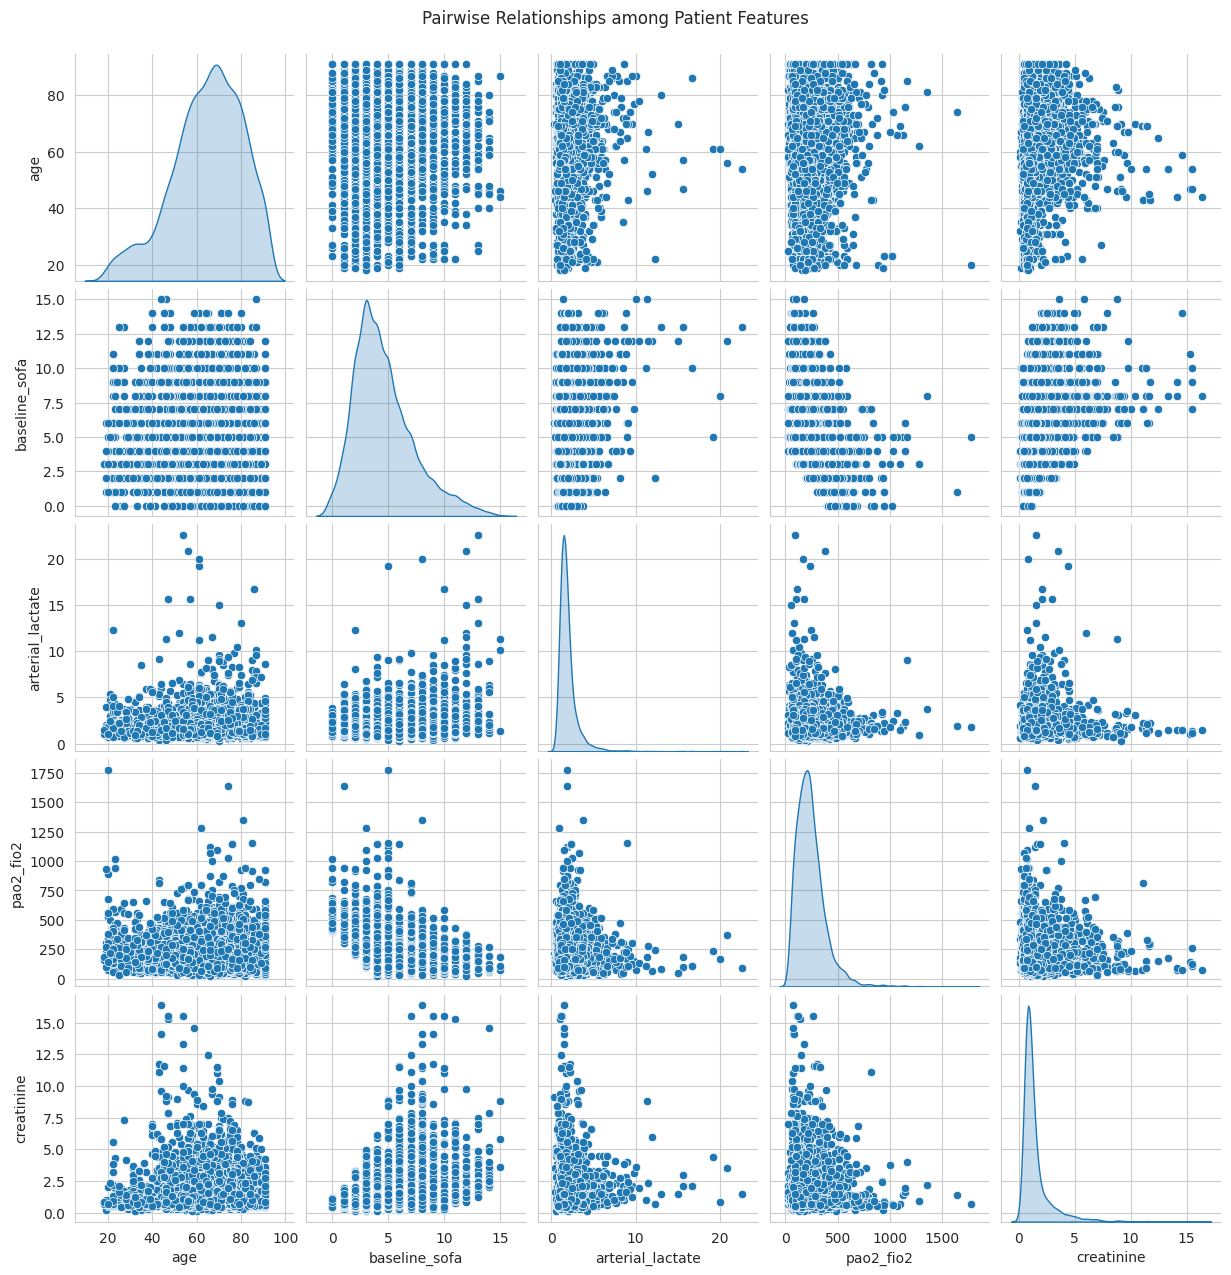

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- pairplot of key continuous features ----
feat_subset = ["age", "baseline_sofa", "arterial_lactate", "pao2_fio2", "creatinine"]
feat_subset = [f for f in feat_subset if f in mimic_df.columns]
sns.pairplot(mimic_df.sample(min(5000, len(mimic_df))), vars=feat_subset, diag_kind="kde") # The diagonal cells show the distribution of each single feature (KDE curves) - kernel density estimate
plt.suptitle("Pairwise Relationships among Patient Features", y=1.02) # Adjusts the vertical position of the title slightly above the figure (by default, it’s at y=1.0).
plt.show()

**Notes:**
* each dot = a “decision point” (one patient state);
* diagonal plots = the *distribution* kde for each variable;
* off-diagonal = *pairwise relationships* between variables.

**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

No major linear relationship

Hard to interpret (e.g pao2-fi02, on oxygen or room air??)

## Step 4: Propensity Matching

Goal: quantify and compare treatment effects where patients receiving different treatment intensities (e.g., vasopressor or fluid doses) are matched on comparable clinical profiles.

1. Compute a composite outcome score that summarizes patient improvement or deterioration.
2. Visualize how this outcome relates to key treatments and physiological factors
3. Apply a custom filtering and matching procedure to ensure fair comparisons across treatment groups.

### 1. Compute composite outcome score

In [24]:
def calculate_composite_outcome(
    df: pd.DataFrame, weights: Optional[Dict[str, float]] = None
) -> pd.Series:
    """
    Calculate composite outcome score (higher = better).
    Uses only available outcome columns: sofa_change and lactate_clearance_pct.

    Args:
        df: DataFrame with outcome columns
        weights: Optional dict of weights for each outcome

    Returns:
        pd.Series with composite outcome score
    """
    if weights is None:
        weights = {
            "sofa": 2.0,
            "lactate_clearance": 0.1,
        }

    composite = pd.Series(0.0, index=df.index)  # new pandas Series called composite, filled with 0.0 values, and having the same index as the DataFrame df

    # Add SOFA change component (negative change = improvement, so we negate it)
    if "sofa_change" in df.columns:
        composite -= weights["sofa"] * df["sofa_change"].fillna(0)

    # Add lactate clearance component (positive clearance = improvement)
    if "lactate_clearance_pct" in df.columns:
        composite += weights["lactate_clearance"] * df["lactate_clearance_pct"].fillna(0)

    return composite

# why fillna?
    # If a certain component (like lactate clearance) is missing, just assume it contributes nothing
    # This keeps the composite score computable and consistent for all rows.

In [25]:
# Calculate composite outcome
# mimic_df["outcome_score"] = calculate_composite_outcome(mimic_df)
mimic_df["outcome_score"] = -mimic_df["sofa_change"]

print("Composite outcome score distribution:")
display(mimic_df["outcome_score"].describe())

Composite outcome score distribution:


,outcome_score
count,144672.000000
mean,-0.117846
std,3.793949
min,-15.000000
25%,-2.000000
50%,-0.000000
75%,2.000000
max,15.000000


### 2. Outcome Relationships and Visualization

#### Distribution of Clinical Outcomes

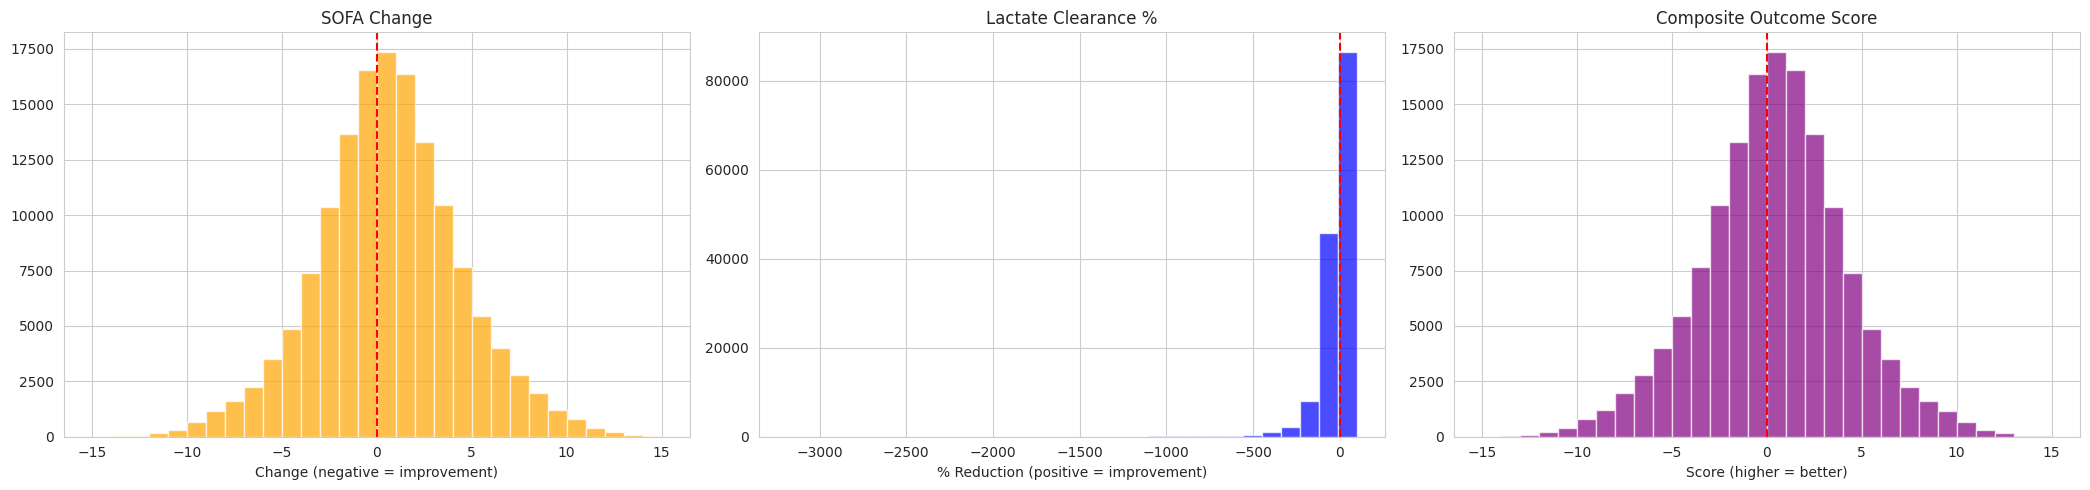

In [26]:
# Visualize outcomes - only show what we have
available_outcomes = []     # Initialize an empty list to store the outcomes available in the dataset

# Check if both 'sofa_change' and 'lactate_clearance_pct' columns exists in mimic_df and has any non-null values
    # If yes, add to available outcomes
if "sofa_change" in mimic_df.columns and mimic_df["sofa_change"].notna().any():
    available_outcomes.append("sofa_change")
if (
    "lactate_clearance_pct" in mimic_df.columns
    and mimic_df["lactate_clearance_pct"].notna().any()
):
    available_outcomes.append("lactate_clearance_pct")

available_outcomes.append("outcome_score")  # Add 'outcome_score' to available outcomes list regardless of whether it has data or not
n_plots = len(available_outcomes)           # Determine how many subplots are needed (one per available outcome)

fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 5))      # Create a figure and a row of subplots, each 7 inches wide and 5 inches tall

if n_plots == 1:        # If there is only one subplot, wrap it in a list for consistency
    axes = [axes]

# Loop through each outcome and plot it
for idx, outcome in enumerate(available_outcomes):

    if outcome == "sofa_change": # Plot a histogram with 30 bins, orange color, and some transparency
        axes[idx].hist(
            mimic_df["sofa_change"].dropna(), bins=30, color="orange", alpha=0.7
        )
        axes[idx].set_title("SOFA Change")
        axes[idx].set_xlabel("Change (negative = improvement)")
        axes[idx].axvline(0, color="red", linestyle="--")

    elif outcome == "lactate_clearance_pct":
        axes[idx].hist(
            mimic_df["lactate_clearance_pct"].dropna(), bins=30, color="blue", alpha=0.7
        )
        axes[idx].set_title("Lactate Clearance %")
        axes[idx].set_xlabel("% Reduction (positive = improvement)")
        axes[idx].axvline(0, color="red", linestyle="--") # Draw a red dashed line at zero to mark the reference point

    elif outcome == "outcome_score":
        axes[idx].hist(
            mimic_df["outcome_score"].dropna(), bins=30, color="purple", alpha=0.7
        )
        axes[idx].set_title("Composite Outcome Score")
        axes[idx].set_xlabel("Score (higher = better)")
        axes[idx].axvline(0, color="red", linestyle="--")

plt.tight_layout() # Adjust subplot layout to avoid overlap
plt.show()

**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

  To create a composite outcome, we're missing tons of data
  
  - mortality
  
  - change of urine output

  - mean arterial blood pressure (has to be above a certain level)

  - discharge / readmission / is staying in the ICU

#### Relationship Between Treatment Intensity and Composite Outcome Score

Goal: Compare how the composite score varies with treatment magnitude (e.g., fluid or vasopressor use). Have boxplots to compare patient outcome scores (y-axis) across different treatment intensity levels (x-axis).

In [27]:
list(mimic_df.columns)

['row_id',
 'pao2_fio2',
 'mechvent',
 'iv_fluid_input',
 'crrt',
 'time_since_admission',
 'age',
 'creatinine',
 'gcs',
 'vasopressor_dose',
 'cumulated_fluid_balance',
 'arterial_lactate',
 'stay_id',
 'baseline_sofa',
 'lactate_clearance_pct',
 'sofa_change',
 'outcome_score']

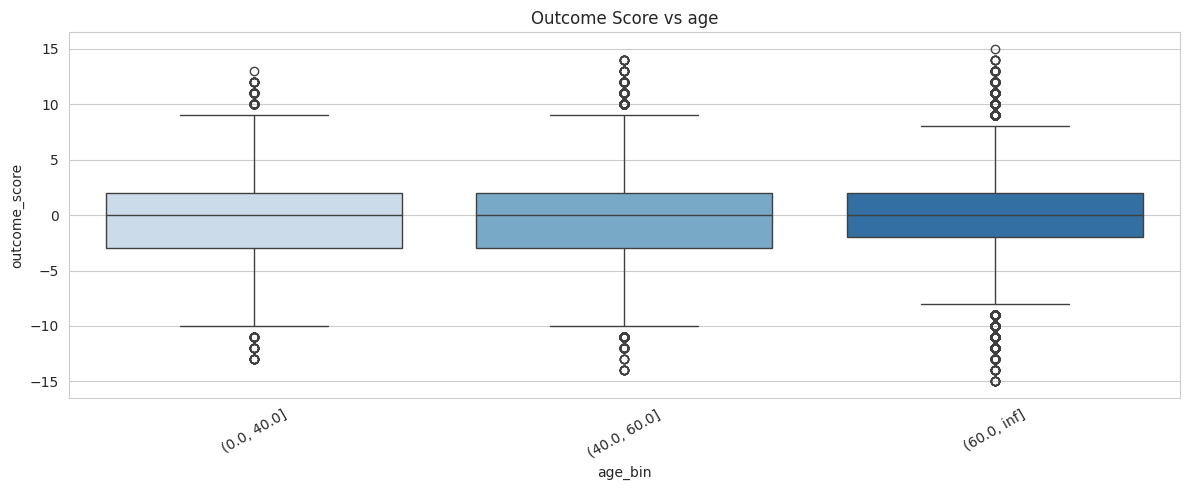

In [28]:
test = mimic_df.copy()
feature = "age"
bins = [0, 40, 60, np.inf]
test[f"{feature}_bin"] = pd.cut(mimic_df[feature], bins=bins)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.boxplot(x=f"{feature}_bin", y="outcome_score", data=test, ax=ax, hue=f"{feature}_bin", palette="Blues", legend = False)
ax.set_title(f"Outcome Score vs {feature}")
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

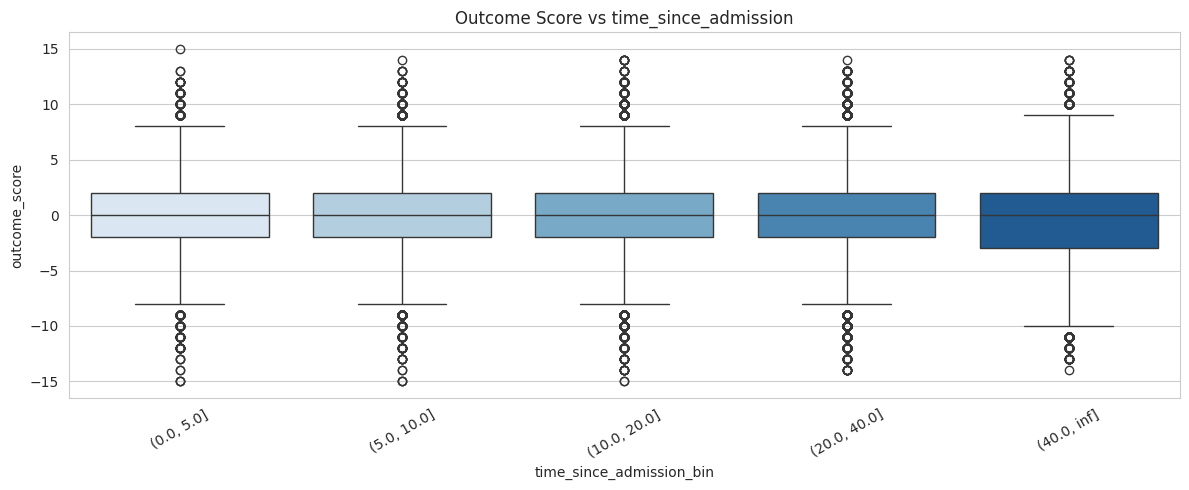

In [29]:
test = mimic_df.copy()
feature = "time_since_admission"
bins = [0, 5, 10, 20, 40, np.inf]
test[f"{feature}_bin"] = pd.cut(mimic_df[feature], bins=bins)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.boxplot(x=f"{feature}_bin", y="outcome_score", data=test, ax=ax, hue=f"{feature}_bin", palette="Blues", legend = False)
ax.set_title(f"Outcome Score vs {feature}")
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

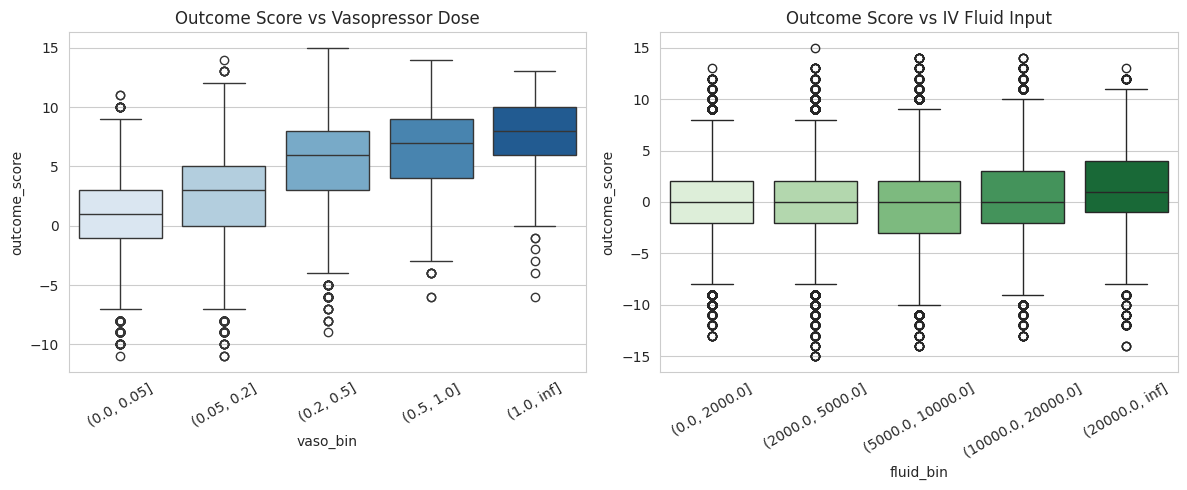

In [30]:
# Define bins for treatments -> Helps compare groups of patients by treatment intensity level rather than raw dosage.
mimic_df["vaso_bin"] = pd.cut(mimic_df["vasopressor_dose"], bins=[0, 0.05, 0.2, 0.5, 1, np.inf])
mimic_df["fluid_bin"] = pd.cut(mimic_df["iv_fluid_input"], bins=[0, 2000, 5000, 10000, 20000, np.inf])

fig, ax = plt.subplots(1, 2, figsize=(12,5))  # 1 row and 2 columns
sns.boxplot(x="vaso_bin", y="outcome_score", data=mimic_df, ax=ax[0], hue="vaso_bin", palette="Blues", legend = False)
sns.boxplot(x="fluid_bin", y="outcome_score", data=mimic_df, ax=ax[1],  hue="fluid_bin", palette="Greens", legend = False)
ax[0].set_title("Outcome Score vs Vasopressor Dose")
ax[1].set_title("Outcome Score vs IV Fluid Input")
for a in ax: a.tick_params(axis='x', rotation=30)# formating in x axis
plt.tight_layout()
plt.show()



**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?


Nothing surprising to the left:

- usually we give more vasopressors to sicker patients who are more lickely to see their vitals decline

- for urine output, we would see a chart similar to vasopressors

#### Correlation Heatmap with Outcome Score

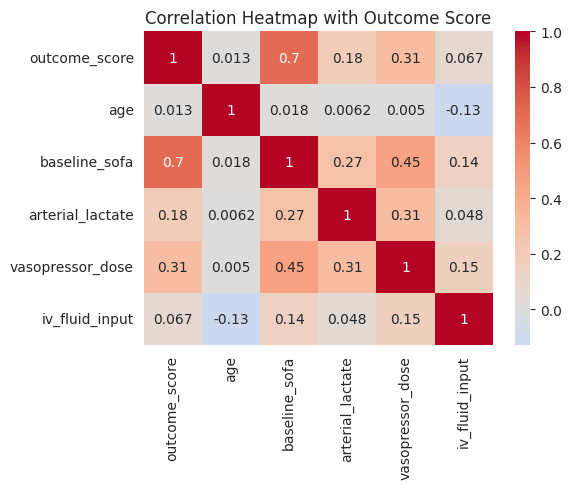

In [31]:
corr = mimic_df[["outcome_score", "age", "baseline_sofa", "arterial_lactate",
                 "vasopressor_dose", "iv_fluid_input"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap with Outcome Score")
plt.tight_layout(); plt.show()


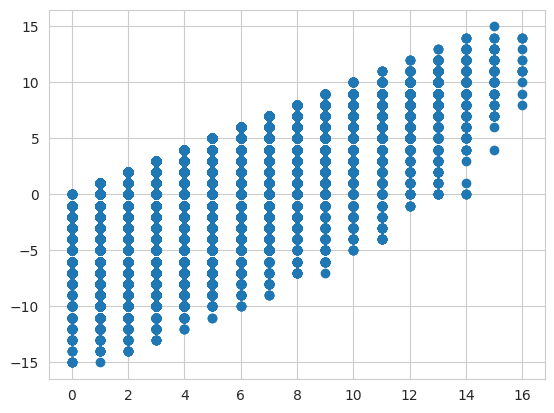

In [32]:
plt.scatter(mimic_df["baseline_sofa"], mimic_df["outcome_score"])

**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

  Not surprising, especially for the SOFA, as it's already in the SOFA change itself, but also from a clinical point of view

  For baseline-sofa/vasopressor-dose + baseline-sofa/arterial-lactate, makes sense from a medical perspective

#### Outcome score across time since admission

/tmp/ipython-input-2365167136.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = mimic_df.groupby(tb)["outcome_score"].mean()
/tmp/ipython-input-2365167136.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c = mimic_df.groupby(tb)["outcome_score"].size()


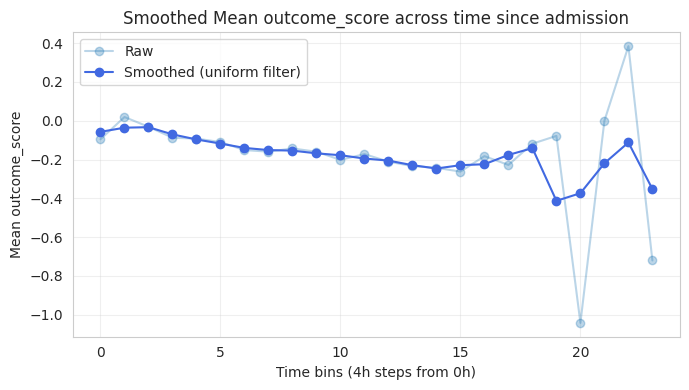

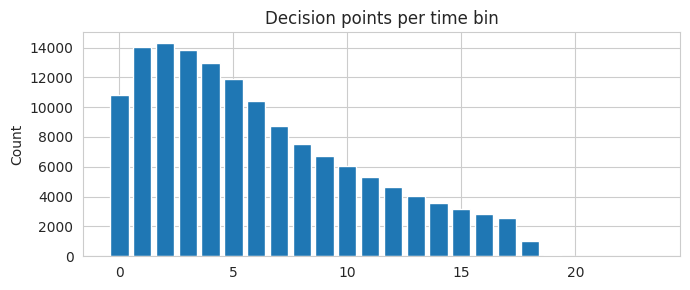

In [33]:
# -------------------------------------------------------------------
# Create time bins for grouping
# -------------------------------------------------------------------
# 'pd.cut' divides the continuous variable 'time_since_admission'
# into equal-width bins every 4 hours (0–4h, 4–8h, ..., up to 96h)
# 'right=False' means intervals are left-inclusive [0,4), [4,8), etc.
tb = pd.cut(mimic_df["time_since_admission"], bins=np.arange(0, 97, 4), right=False)

# -------------------------------------------------------------------
# Compute mean outcome_score within each time bin
# -------------------------------------------------------------------
# Group data by those time bins, then calculate the mean of 'outcome_score'
# This shows the average patient outcome at different times since ICU admission
g = mimic_df.groupby(tb)["outcome_score"].mean()

# -------------------------------------------------------------------
# Count how many decision points fall in each time bin
# -------------------------------------------------------------------
# Group again by the same bins, but this time count the number of rows (observations)
# This is useful to understand how much data contributes to each mean
c = mimic_df.groupby(tb)["outcome_score"].size()

# -------------------------------------------------------------------
# Plot mean outcome_score across time
# -------------------------------------------------------------------
from scipy.ndimage import uniform_filter1d

# Apply 1D moving average with a 3-point window
smooth_values = uniform_filter1d(g.values, size=3)

plt.figure(figsize=(7,4)) # Create a 7x4 inch figure
plt.plot(range(len(g)), g.values, marker="o", alpha=0.3, label="Raw")
plt.plot(range(len(g)), smooth_values, marker="o", color="royalblue", label="Smoothed (uniform filter)")
plt.title("Smoothed Mean outcome_score across time since admission")
plt.xlabel("Time bins (4h steps from 0h)")
plt.ylabel("Mean outcome_score")
plt.legend()
plt.grid(alpha=0.3) # Light grid for readability
plt.tight_layout()  # Adjust layout to avoid overlaps
plt.show()


# -------------------------------------------------------------------
# visualize how many data points each time bin contains
# -------------------------------------------------------------------
plt.figure(figsize=(7,3))
plt.bar(range(len(c)), c.values)              # Bar plot of counts per bin
plt.title("Decision points per time bin")     # Title explaining what it shows
plt.ylabel("Count")                           # Y-axis label for counts
plt.tight_layout()                            # Clean layout
plt.show()                                    # Display the plot


**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

  Effect of antibiotics takes 24h. So spikes and improvement for high time since admission does make sense.

  !! People do come in for sepsis, but also for some other reasons like surgery etc. They can develop it during their stay at the hospital => time since admission is highly likely to be inacurate.

  Survivorship bias to be careful. If a patient stays for at least a few days => he/she has complications => mortality likely to increase anyway => hard to interpret into a model to find an "optimized treatment"

  Already in some hospitals: split patients who come to the emergency with sepsis vs patients who developed it during their stay. Fitting models for both cases would yield better results?


### 3. Filter class for propensity matching

We implement a matching algorithm with:
1. **Filters**: Absolute, percentage, and range-based filters
2. **Model**: Custom K-nearest neighbors in normalized feature space

In [34]:
class Filter:
    """
        Simple filter class for propensity matching
        - Filter class is used to define which rows in your dataset (e.g., patients) are similar enough to a given patient (source_row) for matching purposes.
        - Each filter compares one feature (e.g., age, heart rate, lactate level) between:
            - the source value (from the patient you’re matching), and
            - the values in other patients (rows) in the dataset.
        - The “mode”: how to decide whether two values are close enough.
    """

    # Defines a Filter object used to create inclusion criteria for matching rows (e.g., patients)
    def __init__(
        self,
        feature: str,                     # column name to apply the filter on
        mode: str = "absolute",           # determines how the filtering range is calculated ("absolute", "percentage", or "set")
        width: Optional[float] = None,    # used as tolerance (absolute difference or percentage)
        lower: Optional[float] = None,    # explicit numeric limits for "set" mode
        upper: Optional[float] = None,
    ) -> None:
        # Initialize a Filter object with configuration parameters
        self.feature = feature
        self.mode = mode
        self.width = width
        self.lower = lower
        self.upper = upper

    # Given a dataframe and a reference (source) value, return a boolean Series marking which rows of df satisfy this filter condition
    def get_mask(self, df: pd.DataFrame, source_value: float) -> pd.Series:
        """Returns a boolean Series telling which rows pass that filter"""

        if self.mode == "absolute":         # Mode 1: absolute range around the source_value
            return (df[self.feature] >= source_value - self.width) & (
                df[self.feature] <= source_value + self.width
            )
        # Example: width=5 → keep rows where feature is within [value−5, value+5]

        elif self.mode == "percentage":     # Mode 2: percentage-based range around the source_value
            lower = source_value * (1 - self.width / 100)
            upper = source_value * (1 + self.width / 100)
            # If the value is negative, make sure lower/upper are ordered correctly
            if source_value < 0:
                lower, upper = min(lower, upper), max(lower, upper)
            return (df[self.feature] >= lower) & (df[self.feature] <= upper)
            # Example: width=10 → keep rows within ±10% of source_value

        elif self.mode == "set":            # Mode 3: fixed lower and upper range (independent of the source value.)
            return (df[self.feature] >= self.lower) & (df[self.feature] <= self.upper)
            # Example: lower=20, upper=40 → keep rows where 20 ≤ feature ≤ 40


In [35]:
def find_matches(source_row: pd.Series, df: pd.DataFrame, filters: List[Filter]) -> pd.DataFrame:
    """Find matching patients based on filters"""
    mask = pd.Series([True] * len(df), index=df.index)  # Starts with a mask of all True (everyone is a candidate).
    for filt in filters:    # For each Filter, intersect (&=) with its mask → rows must satisfy all filters (AND logic).
        mask &= filt.get_mask(df, source_row[filt.feature])
    mask[source_row.name] = False # Excludes the source row itself.
    return df[mask]               # Returns the subset DataFrame of rule-based matches.

1. Start with one patient → source_row
2. Apply rule-based filters → get candidate pool matches_df
3. Compute standardized distances in normalized_df → choose the closest ones

In [36]:

def select_top_neighbors(
    source_row: pd.Series,
    matches_df: pd.DataFrame,
    normalized_df: pd.DataFrame,    # is the entire dataset, but with all numeric features standardized (mean = 0, std = 1) -> This lets you calculate Euclidean distances fairly, because age, lactate, and SOFA all have different scales originally.
    distance_features: List[str],   # the columns used to compute distances.
    n_neighbors: int,               # how many closest to keep.
) -> pd.DataFrame:

    """
        Select closest neighbors
        If there are more matches than you want, it narrows them down by closeness in a pre-normalized space.
        Computes Euclidean distances between the source vector and each candidate, sorts, and returns the top K rows.
        Hard filters remove obviously dissimilar patients before distance is used.
    """
    if len(matches_df) == 0 or len(matches_df) <= n_neighbors:
        return matches_df # If there are no matches, or fewer than the desired number of neighbors, just return them all, no need to compute distances.

    # Extracts the feature vector (e.g., [age, SOFA, lactate, ...]) for the source patient from the normalized dataset.
    source_vec = normalized_df.loc[source_row.name, distance_features].values.reshape(1, -1)

    # Extracts the feature vectors for all candidate matches, again from the normalized dataset, using their indices from matches_df
    match_vecs = normalized_df.loc[matches_df.index, distance_features].values
    # now we have:
        # source_vec: a single 1×N vector
        # match_vecs: an M×N matrix of candidate rows

    distances = euclidean_distances(source_vec, match_vecs)[0]  # Calculates Euclidean distance between the source and every candidate using all selected features (Smaller distance = more similar)
    top_k_idx = np.argsort(distances)[:n_neighbors]             # Sorts candidates by distance and keeps only the closest K.
    return matches_df.iloc[top_k_idx]                           # Returns the subset of matches_df corresponding to those top K neighbors.

Context:
- source_row (pd.Series): The patient you’re trying to find similar patients for (the “reference” case). Each element is one feature value, e.g., their age, lactate, SOFA, etc.
- matches_df (pd.DataFrame): The pool of candidate patients that already passed your filter criteria, meaning they are “roughly similar” to the source (e.g., same age range, same lactate range). This is the subset returned by your earlier find_matches() function.

In [37]:
mimic_df["baseline_sofa"].max()

16.0

In [38]:
list(mimic_df.columns)

['row_id',
 'pao2_fio2',
 'mechvent',
 'iv_fluid_input',
 'crrt',
 'time_since_admission',
 'age',
 'creatinine',
 'gcs',
 'vasopressor_dose',
 'cumulated_fluid_balance',
 'arterial_lactate',
 'stay_id',
 'baseline_sofa',
 'lactate_clearance_pct',
 'sofa_change',
 'outcome_score',
 'vaso_bin',
 'fluid_bin']

In [39]:
# Define filters -> creating a Python list of 5 Filter objects
# Each Filter() call uses your custom Filter class to store the rules for one feature
# note: creating a list of matching rules, not the matches themselves.

filters = [
    Filter("age", mode="absolute", width=5),
    Filter("baseline_sofa", mode="absolute", width=2),
    Filter("mechvent", mode="percentage", width=25),
]

distance_features = [
    "age",
    "baseline_sofa",
    "arterial_lactate",
    "pao2_fio2",
    "creatinine",
    "time_since_admission",
]
n_neighbors = 100           # Among the candidates, we’ll keep the K closest (= n_neighbors) using Euclidean distance over these columns.

# Standardizing selected columns (mean 0, std 1) so you can compute Euclidean distances fairly later.
scaler = StandardScaler()   # makes each feature mean 0, std 1, so no single variable (e.g., PaO2/FiO2) dominates distances due to scale.
mimic_normalized = mimic_df.copy()
mimic_normalized[distance_features] = scaler.fit_transform(mimic_df[distance_features]) # Returns the scaled version of the data.
    # Each column in distance_features now has: mean = 0 and standard deviation = 1
    # For example, if age ranges 20–90 and lactate ranges 0–10, this ensures both are on comparable scales so Euclidean distance treats them fairly.

In [40]:
mimic_normalized

,row_id,pao2_fio2,mechvent,iv_fluid_input,crrt,time_since_admission,age,creatinine,gcs,vasopressor_dose,cumulated_fluid_balance,arterial_lactate,stay_id,baseline_sofa,lactate_clearance_pct,sofa_change,outcome_score,vaso_bin,fluid_bin
97,014460_300,-1.367908,0,0.000000,0,-1.383599,-0.555919,3.955492,12.854,0.000,0.000000,-0.480320,014460,2.028971,-43.153846,-6.0,6.0,NaN,NaN
98,014461_300,-0.241706,0,1223.219814,0,-1.329788,-0.555919,0.406095,9.556,0.000,1223.219814,2.426774,014461,0.903656,36.239516,-1.0,1.0,NaN,"(0.0, 2000.0]"
99,014462_300,-0.547017,0,1353.902315,0,-1.275978,-0.555919,0.857480,15.000,0.050,1313.902315,-0.031380,014462,0.528552,6.451613,-1.0,1.0,"(0.0, 0.05]","(0.0, 2000.0]"
100,014463_300,-0.473344,0,1484.398249,0,-1.222168,-0.555919,0.857480,15.000,0.050,1344.398249,-0.070881,014463,0.528552,26.481784,-1.0,1.0,"(0.0, 0.05]","(0.0, 2000.0]"
101,014464_300,-0.797754,0,1549.259580,0,-1.168358,-0.555919,0.857480,15.000,0.025,1409.259580,-0.176469,014464,0.528552,-21.411765,-2.0,2.0,"(0.0, 0.05]","(0.0, 2000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502735,9257841_399,0.245294,0,5834.291617,0,0.876428,0.255236,0.787389,3.000,1.101,2698.291617,1.418748,9257841,2.779180,65.789474,-5.0,5.0,"(1.0, inf]","(5000.0, 10000.0]"
1502736,9257842_399,0.245294,0,5937.064100,0,0.930238,0.255236,0.787389,3.000,1.101,2756.064100,1.418748,9257842,2.779180,65.789474,-5.0,5.0,"(1.0, inf]","(5000.0, 10000.0]"
1502737,9257843_399,0.245294,1,6164.836584,0,0.984048,0.255236,0.787389,3.000,1.101,2975.836584,1.418748,9257843,2.779180,65.789474,-5.0,5.0,"(1.0, inf]","(5000.0, 10000.0]"
1502738,9257844_399,0.245294,0,6234.807517,0,1.037858,0.255236,0.787389,3.000,1.101,3045.807517,1.418748,9257844,2.779180,65.789474,-5.0,5.0,"(1.0, inf]","(5000.0, 10000.0]"


Should have been filters

BMI: obese vs normal weight people will different outcomes

fio2: instead of mechanical ventilation, as it's more accurate

gender: avoid bias, better matching

What we've picked:

age: different outcomes for sure depending on the age

baseline sofa: different score will yield to different outcomes

mechvent: proxy for fi02


## Step 5: Treatment Recommendation

For each patient, we:
1. Find similar patients using filters
2. Select K-nearest neighbors
3. Discretize treatments into bins
4. Recommend the treatment bin with best average outcome

In [41]:
def recommend_treatment(
    matches_df: pd.DataFrame,
    action_column: str = "vasopressor_dose",
    outcome_column: str = "outcome_score",
    bins: Optional[List[float]] = None,
    min_support: int = 10,
) -> Dict[str, Optional[float]]:
    """
    Recommend treatment based on actual outcomes of the matched patients

    Args:
        matches_df: Dataframe with matched patients
        action_column: Column name for the treatment action
        outcome_column: Column name for the outcome measure
        bins: Optional list of bins for discretizing the action
        min_support: Minimum number of matches required for a bin to be considered (avoid noise)

    Returns:
        Dict with recommended action, expected outcome, number of matches, and bin stats
    """
    if bins is None:
        # Default bins for vasopressor (norepinephrine) dose (mcg/kg/min)
        bins = [0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 1.0]

    matches_df = matches_df.copy()

    # Added include_lowest=True to ensure patients with dose=0 are included
    matches_df["action_bin"] = pd.cut(
        matches_df[action_column],
        bins=bins,
        labels=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],    # generates human-readable bin labels (like "0.10–0.20") from your list of bin edges, so the output column action_bin shows clear ranges instead of numerical intervals.
        include_lowest=True,  # Include leftmost edge
    )

    # Build aggregation dict based on available columns
    agg_dict = {outcome_column: ["mean", "std", "count"]}   # For each group (each treatment dose bin), calculate the mean, standard deviation, and number of patients for the column outcome_score

    # Add optional outcome columns if they exist
    # If the DataFrame matches_df has an outcome_score column, and the main outcome (outcome_column) is something else (e.g., "sofa_change"),
    # → then also include outcome_score in the summary and take its mean.
    # This prevents duplicating the same column twice.
    if "outcome_score" in matches_df.columns and outcome_column != "outcome_score":
        agg_dict["outcome_score"] = "mean"
    if "sofa_change" in matches_df.columns:
        agg_dict["sofa_change"] = "mean"
    if "lactate_clearance_pct" in matches_df.columns:
        agg_dict["lactate_clearance_pct"] = "mean"

    # Group the patients by action_bin (e.g., dose range) and compute the mean, std, and count of the outcome for each group.
        # Takes your matches_df (the matched patients), groups them by their treatment dose category (action_bin), and then computes summary statistics (like mean, std, count) for each outcome column, as defined in your agg_dict.
    bin_stats = matches_df.groupby("action_bin", observed=False).agg(agg_dict)

    # FORMATTING
    # Flatten multi-level columns
    if isinstance(bin_stats.columns, pd.MultiIndex): # Check if columns are multi-level (hard to work with)
        new_columns = []                # If yes → we’ll rename them into simple, flat column names.

        for col in bin_stats.columns:   # Loop through each (column_name, aggregation_function) pair
            col_name, agg_func = col
            if col_name == outcome_column:
                if agg_func == "mean":
                    new_columns.append("mean_outcome")
                elif agg_func == "std":
                    new_columns.append("std_outcome")
                elif agg_func == "count":
                    new_columns.append("n_matches")
                else:
                    new_columns.append(f"{col_name}_{agg_func}")
            else:
                # For other columns, just use mean_<colname>
                new_columns.append(f"mean_{col_name}")

        bin_stats.columns = new_columns

    bin_stats = bin_stats.reset_index()

    # Select best action with sufficient support
    valid_bins = bin_stats[bin_stats["n_matches"] >= min_support].copy()

    if len(valid_bins) == 0:
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Find optimal bin based on available outcome
    outcome_col_name = (
        "mean_outcome_score"
        if "mean_outcome_score" in valid_bins.columns
        else "mean_outcome"
    )

    # Remove NaN values before finding optimal bin
    valid_bins_no_nan = valid_bins[valid_bins[outcome_col_name].notna()].copy()

    if len(valid_bins_no_nan) == 0:
        # If all valid bins have NaN outcomes, return no recommendation
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Higher outcome_score = better patient outcome
    optimal_bin = valid_bins_no_nan.loc[valid_bins_no_nan[outcome_col_name].idxmax()]

    result = {
        "recommended_action": optimal_bin["action_bin"],
        "expected_outcome": optimal_bin.get(outcome_col_name, None),
        "n_matches": int(optimal_bin["n_matches"]),
        "bin_stats": bin_stats,
        "total_matches_used": int(bin_stats["n_matches"].sum()),  # Track total usage
    }

    # Add optional outcomes if available
    if "mean_sofa_change" in optimal_bin:
        result["expected_sofa_change"] = optimal_bin["mean_sofa_change"]
    if "mean_lactate_clearance_pct" in optimal_bin:
        result["expected_lactate_clearance"] = optimal_bin["mean_lactate_clearance_pct"]

    return result

In [42]:
def recommend_treatment_median(
    matches_df: pd.DataFrame,
    action_column: str = "vasopressor_dose",
    outcome_column: str = "outcome_score",
    bins: Optional[List[float]] = None,
    min_support: int = 10,
) -> Dict[str, Optional[float]]:
    """
    Recommend treatment based on actual outcomes of the matched patients

    Args:
        matches_df: Dataframe with matched patients
        action_column: Column name for the treatment action
        outcome_column: Column name for the outcome measure
        bins: Optional list of bins for discretizing the action
        min_support: Minimum number of matches required for a bin to be considered (avoid noise)

    Returns:
        Dict with recommended action, expected outcome, number of matches, and bin stats
    """
    if bins is None:
        # Default bins for vasopressor (norepinephrine) dose (mcg/kg/min)
        bins = [0, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 1.0]

    matches_df = matches_df.copy()

    # Added include_lowest=True to ensure patients with dose=0 are included
    matches_df["action_bin"] = pd.cut(
        matches_df[action_column],
        bins=bins,
        labels=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],    # generates human-readable bin labels (like "0.10–0.20") from your list of bin edges, so the output column action_bin shows clear ranges instead of numerical intervals.
        include_lowest=True,  # Include leftmost edge
    )

    # Build aggregation dict based on available columns
    agg_dict = {outcome_column: ["median", "std", "count"]}   # For each group (each treatment dose bin), calculate the mean, standard deviation, and number of patients for the column outcome_score

    # Add optional outcome columns if they exist
    # If the DataFrame matches_df has an outcome_score column, and the main outcome (outcome_column) is something else (e.g., "sofa_change"),
    # → then also include outcome_score in the summary and take its mean.
    # This prevents duplicating the same column twice.
    if "outcome_score" in matches_df.columns and outcome_column != "outcome_score":
        agg_dict["outcome_score"] = "median"
    if "sofa_change" in matches_df.columns:
        agg_dict["sofa_change"] = "median"
    if "lactate_clearance_pct" in matches_df.columns:
        agg_dict["lactate_clearance_pct"] = "median"

    # Group the patients by action_bin (e.g., dose range) and compute the mean, std, and count of the outcome for each group.
        # Takes your matches_df (the matched patients), groups them by their treatment dose category (action_bin), and then computes summary statistics (like mean, std, count) for each outcome column, as defined in your agg_dict.
    bin_stats = matches_df.groupby("action_bin", observed=False).agg(agg_dict)

    # FORMATTING
    # Flatten multi-level columns
    if isinstance(bin_stats.columns, pd.MultiIndex): # Check if columns are multi-level (hard to work with)
        new_columns = []                # If yes → we’ll rename them into simple, flat column names.

        for col in bin_stats.columns:   # Loop through each (column_name, aggregation_function) pair
            col_name, agg_func = col
            if col_name == outcome_column:
                if agg_func == "median":
                    new_columns.append("median_outcome")
                elif agg_func == "std":
                    new_columns.append("std_outcome")
                elif agg_func == "count":
                    new_columns.append("n_matches")
                else:
                    new_columns.append(f"{col_name}_{agg_func}")
            else:
                # For other columns, just use mean_<colname>
                new_columns.append(f"median_{col_name}")

        bin_stats.columns = new_columns

    bin_stats = bin_stats.reset_index()

    # Select best action with sufficient support
    valid_bins = bin_stats[bin_stats["n_matches"] >= min_support].copy()

    if len(valid_bins) == 0:
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Find optimal bin based on available outcome
    outcome_col_name = (
        "median_outcome_score"
        if "median_outcome_score" in valid_bins.columns
        else "median_outcome"
    )

    # Remove NaN values before finding optimal bin
    valid_bins_no_nan = valid_bins[valid_bins[outcome_col_name].notna()].copy()

    if len(valid_bins_no_nan) == 0:
        # If all valid bins have NaN outcomes, return no recommendation
        return {
            "recommended_action": None,
            "expected_outcome": None,
            "n_matches": 0,
            "bin_stats": bin_stats,
            "total_matches_used": int(bin_stats["n_matches"].sum()),
        }

    # Higher outcome_score = better patient outcome
    optimal_bin = valid_bins_no_nan.loc[valid_bins_no_nan[outcome_col_name].idxmax()]

    result = {
        "recommended_action": optimal_bin["action_bin"],
        "expected_outcome": optimal_bin.get(outcome_col_name, None),
        "n_matches": int(optimal_bin["n_matches"]),
        "bin_stats": bin_stats,
        "total_matches_used": int(bin_stats["n_matches"].sum()),  # Track total usage
    }

    # Add optional outcomes if available
    if "median_sofa_change" in optimal_bin:
        result["expected_sofa_change"] = optimal_bin["median_sofa_change"]
    if "median_lactate_clearance_pct" in optimal_bin:
        result["expected_lactate_clearance"] = optimal_bin["median_lactate_clearance_pct"]

    return result

In [43]:
# Example: Recommend treatment for one patient
patient_id = 0
action_column = "vasopressor_dose"
outcome_column = "outcome_score"
bins = None
min_support = 5

source_patient = mimic_df.iloc[patient_id]

# Find matches
all_matches = find_matches(source_patient, mimic_df, filters)
top_matches = select_top_neighbors(
    source_patient, all_matches, mimic_normalized, distance_features, n_neighbors
)

if len(top_matches) > 0:
    recommendation = recommend_treatment(
        top_matches, action_column, outcome_column, bins, min_support
    )

    print("\n" + "=" * 70)
    print("TREATMENT RECOMMENDATION")
    print("=" * 70)
    print(f"\nSource Patient (ID={patient_id}):")
    print(f"  Age: {source_patient['age']:.0f} years")
    print(f"  Baseline SOFA: {source_patient['baseline_sofa']:.0f}")
    print(f"  Lactate: {source_patient['arterial_lactate']:.1f} mmol/L")
    print(f"  Current vasopressor: {source_patient['vasopressor_dose']:.3f} mcg/kg/min")

    print(f"\nMatched {len(all_matches)} similar patients from filters")
    print(f"Matched {len(top_matches)} similar patients from top neighbors")

    # Show how many patients were actually used
    if "total_matches_used" in recommendation:
        print(
            f"Using {recommendation['total_matches_used']} out of {len(top_matches)} matched patients in recommendation"
        )

    if recommendation["recommended_action"] is not None:
        print(f"\n" + "-" * 70)
        print(f"Recommended dose: {recommendation['recommended_action']} mcg/kg/min")
        print(f"-" * 70)
        print(
            f"Expected outcomes (based on {recommendation['n_matches']} similar patients):"
        )
        print(f"  - Composite outcome score: {recommendation['expected_outcome']:.2f}")
        if "expected_sofa_change" in recommendation:
            print(
                f"  - SOFA change: {recommendation['expected_sofa_change']:.2f} (negative=improvement)"
            )
        if "expected_lactate_clearance" in recommendation:
            print(
                f"  - Lactate clearance: {recommendation['expected_lactate_clearance']:.1f}%"
            )

        print(f"\nAll treatment options:")
        display(recommendation["bin_stats"])
    else:
        print("\nInsufficient matches for recommendation.")
else:
    print(f"No matches found for patient {patient_id}")


TREATMENT RECOMMENDATION

Source Patient (ID=0):
  Age: 56 years
  Baseline SOFA: 10
  Lactate: 1.3 mmol/L
  Current vasopressor: 0.000 mcg/kg/min

Matched 3104 similar patients from filters
Matched 100 similar patients from top neighbors
Using 100 out of 100 matched patients in recommendation

----------------------------------------------------------------------
Recommended dose: 0.05-0.10 mcg/kg/min
----------------------------------------------------------------------
Expected outcomes (based on 10 similar patients):
  - Composite outcome score: 4.10
  - SOFA change: -4.10 (negative=improvement)
  - Lactate clearance: -27.3%

All treatment options:


,action_bin,mean_outcome,std_outcome,n_matches,mean_sofa_change,mean_lactate_clearance_pct
0,0.00-0.05,3.279070,2.565156,86,-3.279070,-47.409169
1,0.05-0.10,4.100000,1.852926,10,-4.100000,-27.317811
2,0.10-0.15,4.666667,0.577350,3,-4.666667,-23.515128
3,0.15-0.20,NaN,NaN,0,NaN,NaN
4,0.20-0.30,6.000000,NaN,1,-6.000000,-30.769231
5,0.30-0.50,NaN,NaN,0,NaN,NaN
6,0.50-1.00,NaN,NaN,0,NaN,NaN


Comments:

Vasopressor dose shouldn't be considered as an action/treatment, as it's already determined by the patient's blood pressure and shouldn't be tuned to improve the outcome.

Many patients have 0 vasopressor dose, which is normal if they've reach their targeted blood pressure.

80%

So the 86 patients close to the patient above with no vasopressor_dose is normal.

In [44]:
100.0 * (mimic_df["vasopressor_dose"] == 0).sum() / mimic_df.shape[0]

np.float64(79.10238332227384)

Another example, with fluid:

(array([2.5161e+04, 1.7615e+04, 1.6789e+04, 1.5843e+04, 1.4899e+04,
        1.2920e+04, 1.0680e+04, 8.1260e+03, 5.6340e+03, 4.0750e+03,
        3.0490e+03, 2.0720e+03, 1.6410e+03, 1.3310e+03, 1.0870e+03,
        7.0200e+02, 4.9800e+02, 4.6300e+02, 4.0600e+02, 4.0100e+02,
        2.9800e+02, 2.5200e+02, 1.3300e+02, 1.0400e+02, 9.5000e+01,
        6.3000e+01, 7.3000e+01, 5.6000e+01, 2.1000e+01, 2.4000e+01,
        1.3000e+01, 1.3000e+01, 7.0000e+00, 8.0000e+00, 4.0000e+00,
        5.0000e+00, 2.0000e+00, 5.0000e+00, 5.0000e+00, 8.0000e+00,
        8.0000e+00, 6.0000e+00, 6.0000e+00, 1.0000e+00, 5.0000e+00,
        8.0000e+00, 1.4000e+01, 3.3000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([    0.        ,  1196.73931065,  2393.47862129,  3590.21793194,
         4786.95724259,  5983.69655324,  7180.43586388,  8377.17517453,
         9573.91448518, 10770.65379583

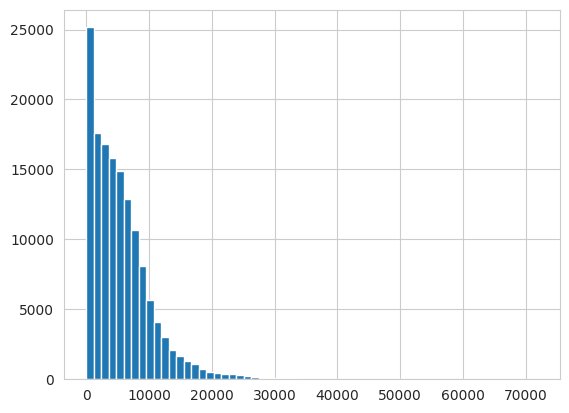

In [45]:
plt.hist(mimic_df["iv_fluid_input"], bins=60)

Comment:

Guidelines for sepsis exist and are targeted:

30ml/kg baseline, in the first 2 hours (2.1L for a 70kg patient, equivalent of what we drink in 24h)

No guideline for 24h. Then, we target a urine output to adjust the dosage: 0.5ml/kg/h

So hard to select bins and a cutoff there, as we don't have the weight and the urine output, let alone at every timestamp.

In [46]:
# Example: Recommend treatment for one patient
patient_id = 9
action_column = "iv_fluid_input"
outcome_column = "outcome_score"
bins = [0, 3000, 5000, np.inf]
min_support = 5

source_patient = mimic_df.iloc[patient_id]

# Find matches
all_matches = find_matches(source_patient, mimic_df, filters)
top_matches = select_top_neighbors(
    source_patient, all_matches, mimic_normalized, distance_features, n_neighbors
)

if len(top_matches) > 0:
    recommendation = recommend_treatment(
        top_matches, action_column, outcome_column, bins, min_support
    )

    print("\n" + "=" * 70)
    print("TREATMENT RECOMMENDATION")
    print("=" * 70)
    print(f"\nSource Patient (ID={patient_id}):")
    print(f"  Age: {source_patient['age']:.0f} years")
    print(f"  Baseline SOFA: {source_patient['baseline_sofa']:.0f}")
    print(f"  Lactate: {source_patient['arterial_lactate']:.1f} mmol/L")
    print(f"  Current iv fluid input: {source_patient['iv_fluid_input']:.3f}mL")

    print(f"\nMatched {len(all_matches)} similar patients from filters")
    print(f"Matched {len(top_matches)} similar patients from top neighbors")

    # Show how many patients were actually used
    if "total_matches_used" in recommendation:
        print(
            f"Using {recommendation['total_matches_used']} out of {len(top_matches)} matched patients in recommendation"
        )

    if recommendation["recommended_action"] is not None:
        print(f"\n" + "-" * 70)
        print(f"Recommended dose: {recommendation['recommended_action']} ml")
        print(f"-" * 70)
        print(
            f"Expected outcomes (based on {recommendation['n_matches']} similar patients):"
        )
        print(f"  - Composite outcome score: {recommendation['expected_outcome']:.2f}")
        if "expected_sofa_change" in recommendation:
            print(
                f"  - SOFA change: {recommendation['expected_sofa_change']:.2f} (negative=improvement)"
            )
        if "expected_lactate_clearance" in recommendation:
            print(
                f"  - Lactate clearance: {recommendation['expected_lactate_clearance']:.1f}%"
            )

        print(f"\nAll treatment options:")
        display(recommendation["bin_stats"])
    else:
        print("\nInsufficient matches for recommendation.")
else:
    print(f"No matches found for patient {patient_id}")


TREATMENT RECOMMENDATION

Source Patient (ID=9):
  Age: 56 years
  Baseline SOFA: 6
  Lactate: 1.7 mmol/L
  Current iv fluid input: 2116.360mL

Matched 13233 similar patients from filters
Matched 100 similar patients from top neighbors
Using 100 out of 100 matched patients in recommendation

----------------------------------------------------------------------
Recommended dose: 3000.00-5000.00 ml
----------------------------------------------------------------------
Expected outcomes (based on 18 similar patients):
  - Composite outcome score: 2.33
  - SOFA change: -2.33 (negative=improvement)
  - Lactate clearance: -154.5%

All treatment options:


,action_bin,mean_outcome,std_outcome,n_matches,mean_sofa_change,mean_lactate_clearance_pct
0,0.00-3000.00,0.219178,2.636531,73,-0.219178,-16.727233
1,3000.00-5000.00,2.333333,1.782266,18,-2.333333,-154.472845
2,5000.00-inf,-1.111111,3.257470,9,1.111111,-49.924557


Histogram closest patients

(array([ 7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,
         1.,  0.,  1.,  1.,  2.,  3.,  5.,  8.,  7.,  3.,  7.,  7.,  8.,
        24.,  8.,  4.,  1.]),
 array([-358.33333333, -343.94444444, -329.55555556, -315.16666667,
        -300.77777778, -286.38888889, -272.        , -257.61111111,
        -243.22222222, -228.83333333, -214.44444444, -200.05555556,
        -185.66666667, -171.27777778, -156.88888889, -142.5       ,
        -128.11111111, -113.72222222,  -99.33333333,  -84.94444444,
         -70.55555556,  -56.16666667,  -41.77777778,  -27.38888889,
         -13.        ,    1.38888889,   15.77777778,   30.16666667,
          44.55555556,   58.94444444,   73.33333333]),
 <BarContainer object of 30 artists>)

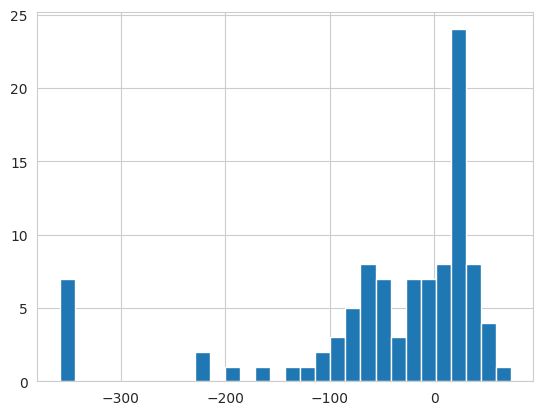

In [47]:
plt.hist(top_matches["lactate_clearance_pct"], bins=30)

Test with median recommendation

In [48]:
n_neighbors = 1000

In [49]:
# Example: Recommend treatment for one patient
patient_id = 7
action_column = "iv_fluid_input"
outcome_column = "outcome_score"
bins = [0, 3000, 5000, np.inf]
min_support = 5

source_patient = mimic_df.iloc[patient_id]

# Find matches
all_matches = find_matches(source_patient, mimic_df, filters)
top_matches = select_top_neighbors(
    source_patient, all_matches, mimic_normalized, distance_features, n_neighbors
)

if len(top_matches) > 0:
    recommendation = recommend_treatment_median(
        top_matches, action_column, outcome_column, bins, min_support
    )

    print("\n" + "=" * 70)
    print("TREATMENT RECOMMENDATION")
    print("=" * 70)
    print(f"\nSource Patient (ID={patient_id}):")
    print(f"  Age: {source_patient['age']:.0f} years")
    print(f"  Baseline SOFA: {source_patient['baseline_sofa']:.0f}")
    print(f"  Lactate: {source_patient['arterial_lactate']:.1f} mmol/L")
    print(f"  Current iv fluid input: {source_patient['iv_fluid_input']:.3f}mL")

    print(f"\nMatched {len(all_matches)} similar patients from filters")
    print(f"Matched {len(top_matches)} similar patients from top neighbors")

    # Show how many patients were actually used
    if "total_matches_used" in recommendation:
        print(
            f"Using {recommendation['total_matches_used']} out of {len(top_matches)} matched patients in recommendation"
        )

    if recommendation["recommended_action"] is not None:
        print(f"\n" + "-" * 70)
        print(f"Recommended dose: {recommendation['recommended_action']} ml")
        print(f"-" * 70)
        print(
            f"Expected outcomes (based on {recommendation['n_matches']} similar patients):"
        )
        print(f"  - Composite outcome score: {recommendation['expected_outcome']:.2f}")
        if "expected_sofa_change" in recommendation:
            print(
                f"  - SOFA change: {recommendation['expected_sofa_change']:.2f} (negative=improvement)"
            )
        if "expected_lactate_clearance" in recommendation:
            print(
                f"  - Lactate clearance: {recommendation['expected_lactate_clearance']:.1f}%"
            )

        print(f"\nAll treatment options:")
        display(recommendation["bin_stats"])
    else:
        print("\nInsufficient matches for recommendation.")
else:
    print(f"No matches found for patient {patient_id}")


TREATMENT RECOMMENDATION

Source Patient (ID=7):
  Age: 56 years
  Baseline SOFA: 5
  Lactate: 1.7 mmol/L
  Current iv fluid input: 1854.794mL

Matched 17871 similar patients from filters
Matched 1000 similar patients from top neighbors
Using 1000 out of 1000 matched patients in recommendation

----------------------------------------------------------------------
Recommended dose: 0.00-3000.00 ml
----------------------------------------------------------------------
Expected outcomes (based on 685 similar patients):
  - Composite outcome score: 1.00
  - SOFA change: -1.00 (negative=improvement)
  - Lactate clearance: -10.7%

All treatment options:


,action_bin,median_outcome,std_outcome,n_matches,median_sofa_change,median_lactate_clearance_pct
0,0.00-3000.00,1.0,2.755692,685,-1.0,-10.701107
1,3000.00-5000.00,1.0,3.080619,160,-1.0,-24.859084
2,5000.00-inf,1.0,2.594377,155,-1.0,-31.250000


Median makes more sense, but harder to interpret and compare for the SOFA score as it is an integer.

Higher number of matches/neighbors could provide a better result?

Dataset quality is the key. We can see even above the impact of outliers on the data.

## Step 6: Visualize Treatment/Outcome Relationship

This code generates visual summaries that help you see how different vasopressor doses compare in terms of outcome score, SOFA improvement, and data support, and highlights the recommended dose visually.

KeyError: 'mean_outcome'

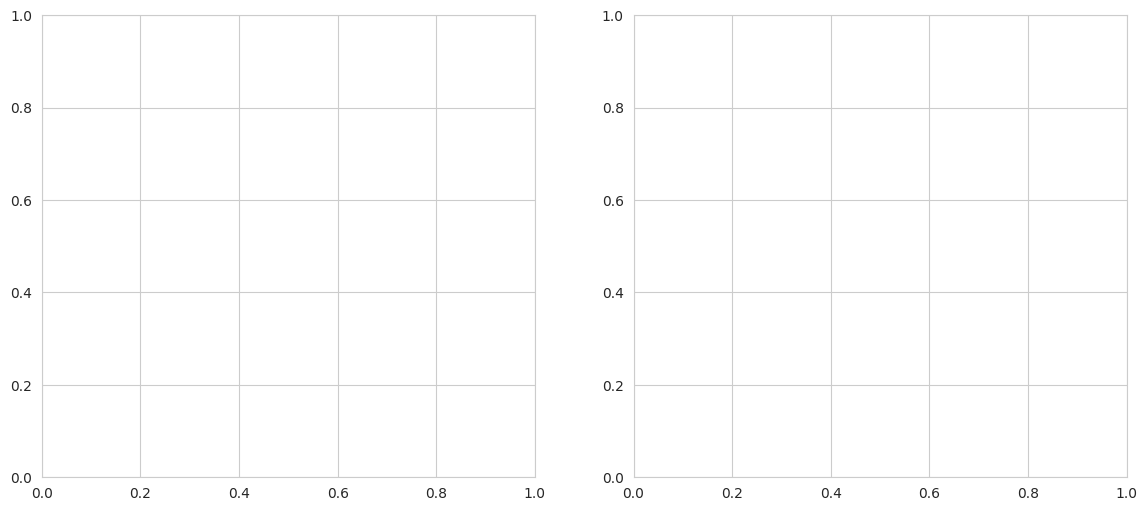

In [50]:
if len(top_matches) > 0 and recommendation["recommended_action"] is not None:
    bin_stats = recommendation["bin_stats"].copy()

    # Determine number of plots based on available data
    n_plots = 2  # Always have composite outcome and sample size
    if "mean_sofa_change" in bin_stats.columns:
        n_plots += 1

    fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))
    if n_plots == 1:
        axes = [axes]

    x_pos = np.arange(len(bin_stats))
    colors = [
        "green" if action == recommendation["recommended_action"] else "steelblue"
        for action in bin_stats["action_bin"]
    ]

    plot_idx = 0

    # Plot 1: Composite outcome (always shown) - HIGHER IS BETTER
    # Add confidence intervals (using standard error = std / sqrt(n))
    means = bin_stats["mean_outcome"].fillna(0)
    stds = bin_stats["std_outcome"].fillna(0)
    n_samples = bin_stats["n_matches"].fillna(1)
    std_errors = stds / np.sqrt(n_samples)

    axes[plot_idx].bar(
        x_pos,
        means,
        color=colors,
        alpha=0.7,
        yerr=std_errors,
        capsize=5,
        error_kw={"elinewidth": 2, "alpha": 0.7},
    )
    axes[plot_idx].set_xticks(x_pos)
    axes[plot_idx].set_xticklabels(bin_stats["action_bin"], rotation=45, ha="right")
    # axes[plot_idx].set_xlabel("Vasopressor Dose (mcg/kg/min)")
    axes[plot_idx].set_xlabel("IV Fluid Input")
    axes[plot_idx].set_ylabel("Mean Outcome Score")
    axes[plot_idx].set_title(
        "Composite Outcome by Treatment Dose\n(Higher = Better, error bars show 95% CI)"
    )
    axes[plot_idx].axhline(0, color="black", linestyle="-", alpha=0.3, linewidth=0.5)
    axes[plot_idx].grid(axis="y", alpha=0.3)
    plot_idx += 1

    # Plot 2: SOFA change (if available) - NEGATIVE IS BETTER (improvement)
    if "mean_sofa_change" in bin_stats.columns:
        sofa_means = bin_stats["mean_sofa_change"].fillna(0)
        # Negate for visualization so higher bars = better outcomes
        sofa_means_inverted = -sofa_means

        axes[plot_idx].bar(x_pos, sofa_means_inverted, color=colors, alpha=0.7)
        axes[plot_idx].axhline(
            0, color="black", linestyle="-", alpha=0.3, linewidth=0.5
        )
        axes[plot_idx].set_xticks(x_pos)
        axes[plot_idx].set_xticklabels(bin_stats["action_bin"], rotation=45, ha="right")
        # axes[plot_idx].set_xlabel("Vasopressor Dose (mcg/kg/min)")
        axes[plot_idx].set_xlabel("IV Fluid Input")
        axes[plot_idx].set_ylabel("SOFA Improvement Score")
        axes[plot_idx].set_title(
            "SOFA Score Change by Treatment\n(Higher = Better, inverted from negative scale)"
        )
        axes[plot_idx].grid(axis="y", alpha=0.3)
        plot_idx += 1

    # Plot 3: Sample size (always shown)
    axes[plot_idx].bar(x_pos, bin_stats["n_matches"], color="coral", alpha=0.7)
    axes[plot_idx].axhline(
        10, color="red", linestyle="--", label="Min threshold", linewidth=2
    )
    axes[plot_idx].set_xticks(x_pos)
    axes[plot_idx].set_xticklabels(bin_stats["action_bin"], rotation=45, ha="right")
    # axes[plot_idx].set_xlabel("Vasopressor Dose (mcg/kg/min)")
    axes[plot_idx].set_xlabel("IV Fluid Input")
    axes[plot_idx].set_ylabel("Number of Matched Patients")
    axes[plot_idx].set_title("Support per Treatment Bin")
    axes[plot_idx].legend()
    axes[plot_idx].grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()


**Questions:**
  - Comment on the plots above.
  - Can the doctors notice any patterns they would like to discuss?

## Step 7: Batch Processing

Process multiple patients to evaluate the recommendation system

In [51]:
def process_patient(
    patient_id: int,
    df: pd.DataFrame,
    normalized_df: pd.DataFrame,
    filters: List[Filter],
    n_neighbors: int,
    action_column: str = "vasopressor_dose",
    outcome_column: str = "outcome_score",
    bins: Optional[List[float]] = None,
    min_support: int = 10,
) -> Optional[Dict[str, Optional[float]]]:
    """Process a single patient and return recommendation results

    Args:
        patient_id: Index of the patient in the dataframe
        df: Original dataframe
        normalized_df: Normalized dataframe for distance calculations
        filters: List of Filter objects for matching
        n_neighbors: Number of neighbors to select
        action_column: Column name for treatment action
        outcome_column: Column name for outcome measure
        bins: Optional list of bins for discretizing the action
        min_support: Minimum number of matches required for a bin to be considered

    Returns:
        Dict with recommendation results or None if no recommendation"""
    source_patient = df.iloc[patient_id]
    all_matches = find_matches(source_patient, df, filters)

    if len(all_matches) == 0:
        return None

    top_matches = select_top_neighbors(
        source_patient, all_matches, normalized_df, distance_features, n_neighbors
    )
    recommendation = recommend_treatment(top_matches, action_column, outcome_column, bins, min_support)
    # recommendation = recommend_treatment_median(top_matches, action_column, outcome_column, bins, min_support)

    if recommendation["recommended_action"] is None:
        return None

    result = {
        "patient_id": patient_id,
        "age": source_patient["age"],
        "baseline_sofa": source_patient["baseline_sofa"],
        "lactate": source_patient["arterial_lactate"],
        # "current_dose": source_patient["vasopressor_dose"],
        "current_dose": source_patient["iv_fluid_input"],
        "current_outcome": source_patient["outcome_score"],
        "recommended_action": recommendation["recommended_action"],
        "expected_outcome": recommendation["expected_outcome"],
        "n_matches": recommendation["n_matches"],
    }

    return result

In [52]:
# need to have ipywidgets as part of the conda env.

# Process a sample of patients
n_neighbors = 500
n_patients_to_process = 1000
action_column = "iv_fluid_input"
min_support = 5
bins = [0, 3000, 5000, np.inf]


n_patients_to_process = min(n_patients_to_process, len(mimic_df))
results = []
print(f"Processing {n_patients_to_process} patients...")
for i in tqdm(range(n_patients_to_process)):
    result = process_patient(i, mimic_df, mimic_normalized, filters, n_neighbors, action_column=action_column, bins=bins, min_support=min_support)
    if result is not None:
        results.append(result)

results_df = pd.DataFrame(results)
print(f"\nSuccessfully processed {len(results_df)} patients with recommendations")

Processing 1000 patients...


  0%|          | 0/1000 [00:00<?, ?it/s]


Successfully processed 1000 patients with recommendations


In [53]:
if len(results_df) > 0:
    results_df["outcome_improvement"] = (
        results_df["expected_outcome"] - results_df["current_outcome"]
    )

    # Add column to check if current dose matches recommendation
    def dose_matches_recommendation(row: pd.Series) -> bool:
        """Check if current dose falls within recommended action bin

        Uses same logic as pd.cut with include_lowest=True:
        - First bin: [lower, upper] (closed on both sides)
        - Other bins: (lower, upper] (left-open, right-closed)
        """
        try:
            # Parse recommended action bin (e.g., "0.00-0.05")
            bin_str = str(row["recommended_action"])
            lower, upper = map(float, bin_str.split("-"))
            current = row["current_dose"]

            # Check if this is the first bin (leftmost)
            is_first_bin = lower == 0.0  # Assuming bins start at 0

            if is_first_bin:
                # First bin: closed on both sides [lower, upper]
                return lower <= current <= upper
            else:
                # Other bins: left-open, right-closed (lower, upper]
                return lower < current <= upper
        except:
            return False

    results_df["dose_matches_rec"] = results_df.apply(
        dose_matches_recommendation, axis=1
    )

    print("\n" + "=" * 70)
    print(f"BATCH PROCESSING RESULTS: {len(results_df)} patients")
    print("=" * 70)

    # FIX: Separate analysis for patients already on recommended dose vs those needing change
    patients_on_rec_dose = results_df[results_df["dose_matches_rec"]]
    patients_need_change = results_df[~results_df["dose_matches_rec"]]

    n_on_rec_dose = len(patients_on_rec_dose)
    n_need_change = len(patients_need_change)

    # Count improvements only among those who need dose changes
    n_would_improve_from_change = (
        patients_need_change["outcome_improvement"] > 0
    ).sum()
    median_improvement_from_change = patients_need_change["outcome_improvement"].median()

    print(
        f"\nPatients already on recommended dose: {n_on_rec_dose} ({100*n_on_rec_dose/len(results_df):.1f}%)"
    )
    print(
        f"Patients who would benefit from dose change: {n_need_change} ({100*n_need_change/len(results_df):.1f}%)"
    )

    if n_need_change > 0:
        print(
            f"  - Of those needing change, {n_would_improve_from_change} would see outcome improvement ({100*n_would_improve_from_change/n_need_change:.1f}%)"
        )
        print(
            f"  - Median expected outcome improvement for those needing change: {median_improvement_from_change:.2f}"
        )

    # Overall statistics (for completeness)
    print(f"\nOverall statistics:")
    print(
        f"  - Total patients with positive outcome improvement: {(results_df['outcome_improvement'] > 0).sum()} ({100*(results_df['outcome_improvement'] > 0).mean():.1f}%)"
    )
    print(
        f"  - Median expected outcome improvement (all patients): {results_df['outcome_improvement'].median():.2f}"
    )
    print(
        f"  - Median number of matches per patient: {results_df['n_matches'].median():.0f}"
    )

    print("\nSample recommendations:")
    display_cols = [
        "patient_id",
        "lactate",
        "current_dose",
        "recommended_action",
        "dose_matches_rec",
        "outcome_improvement",
    ]
    display(results_df[display_cols].head(10))
else:
    print("No patients could be processed with sufficient matches.")


BATCH PROCESSING RESULTS: 1000 patients

Patients already on recommended dose: 328 (32.8%)
Patients who would benefit from dose change: 672 (67.2%)
  - Of those needing change, 392 would see outcome improvement (58.3%)
  - Median expected outcome improvement for those needing change: 0.90

Overall statistics:
  - Total patients with positive outcome improvement: 546 (54.6%)
  - Median expected outcome improvement (all patients): 0.52
  - Median number of matches per patient: 126

Sample recommendations:


,patient_id,lactate,current_dose,recommended_action,dose_matches_rec,outcome_improvement
0,0,1.300,0.000000,5000.00-inf,False,-0.682353
1,1,5.127,1223.219814,3000.00-5000.00,False,0.854839
2,2,1.891,1353.902315,3000.00-5000.00,False,0.780000
3,3,1.839,1484.398249,3000.00-5000.00,False,0.642857
4,4,1.700,1549.259580,3000.00-5000.00,False,-0.164384
5,5,1.700,1583.294780,3000.00-5000.00,False,0.861111
6,6,1.700,1814.271158,3000.00-5000.00,False,-0.120000
7,7,1.700,1854.794074,3000.00-5000.00,False,-1.075949
8,8,1.700,1994.720332,3000.00-5000.00,False,-0.234568
9,9,1.700,2116.360160,3000.00-5000.00,False,-0.073171


**TODO**

SOFA/age for clustering

Litterature review to conduct

No guidelines on fluid input for patients with sepsis when no vasopressor are required

##Step 7.5: Focus on patients with no vasopressor

Vasopressor can be a confounding factor. We want to focus on patients with sepsis with no vasopressor, also so that it's more targeted and we just need the fluids input as an action.

In [54]:
distance_features

['age',
 'baseline_sofa',
 'arterial_lactate',
 'pao2_fio2',
 'creatinine',
 'time_since_admission']

In [61]:
distance_features_v2 = ["age", "baseline_sofa"]

In [58]:
100.0 * (mimic_df["vasopressor_dose"] == 0.0).sum() / mimic_df.shape[0]

np.float64(79.10238332227384)

In [59]:
mimic_df_filtered = mimic_df[mimic_df["vasopressor_dose"] == 0.0]

In [60]:
print(f"{len(mimic_df_filtered)} patients in our new database")

114439 patients in our new database


In [62]:
scaler = StandardScaler()
mimic_df_filtered_normalized = mimic_df_filtered.copy()
mimic_df_filtered_normalized[distance_features_v2] = scaler.fit_transform(mimic_df_filtered[distance_features_v2])

In [63]:
i = 0
result = process_patient(i, mimic_df_filtered, mimic_df_filtered_normalized, filters, n_neighbors, action_column=action_column, bins=bins, min_support=min_support)
result

{'patient_id': 0,
 'age': np.float64(56.0),
 'baseline_sofa': np.float64(10.0),
 'lactate': np.float64(1.3),
 'current_dose': np.float64(0.0),
 'current_outcome': np.float64(6.0),
 'recommended_action': '5000.00-inf',
 'expected_outcome': np.float64(4.596774193548387),
 'n_matches': 124}

In [ ]:
# Process a sample of patients
n_neighbors = 500
n_patients_to_process = 1000
action_column = "iv_fluid_input"
min_support = 5
bins = [0, 3000, 5000, np.inf]


n_patients_to_process = min(n_patients_to_process, len(mimic_df_filtered))
results = []
print(f"Processing {n_patients_to_process} patients...")
for i in tqdm(range(n_patients_to_process)):
    result = process_patient(i, mimic_df_filtered, mimic_df_filtered_normalized, filters, n_neighbors, action_column=action_column, bins=bins, min_support=min_support)
    if result is not None:
        results.append(result)

results_df = pd.DataFrame(results)
print(f"\nSuccessfully processed {len(results_df)} patients with recommendations")

## Step 8: Towards more Machine Learning Enhancement

**Deep Learning + multi-task learning**: Learn the treatment + the outcome

**Causal Forests**: heterogenous treatment effects

**Reinforcement Learning**: DDQN, SQC, etc, optimal policy